In [1]:
import scanpy as sc
import os
import numpy as np
import pandas as pd
import leidenalg
import anndata as ad
import scrublet as scr
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import milopy
import milopy.core as milo
import scvelo as scv
import warnings
warnings.filterwarnings("ignore")
import umap.plot
import milopy.plot as milopl
import milopy.utils
import plotly.express as px
import seaborn as sns
from pyslingshot import Slingshot
import gseapy as gp
from gseapy import barplot, dotplot
from gseapy import Msigdb
from gseapy import enrichment_map
import networkx as nx
from scipy.stats import chi2_contingency
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
from scipy.stats import wilcoxon
import scipy.stats
from scipy.stats import entropy
from scipy.stats import mannwhitneyu



In [2]:
in_dat = sc.read_csv('/Users/tomwolstenholme-hogg/anaconda3/envs/dissertation/GSE138852_counts.csv').transpose()
adata = sc.AnnData(in_dat)
adata.var_names_make_unique()
adata.obs_names_make_unique()

In [3]:
labels = pd.read_csv('/Users/tomwolstenholme-hogg/anaconda3/envs/dissertation/scRNA_metadata.tsv', sep='\t')
selected_column = 'cellType'
adata.obs['cell_type'] = labels[selected_column].values

# Editing the names of the cell types so they are their actual names
replacement_dict = {'oligo': 'Oligodendrocyte', 'astro': 'Astrocyte', 'mg': 'Microglia',
                    'endo': 'Endothelial', 'neuron': 'Neuron', 'OPC': 'OPC', 'doublet':'Doublet',
                    'unID':'unID'}

adata.obs['cell_type'] = adata.obs['cell_type'].replace(replacement_dict)

adata.obs


cell_type
AAACCTGGTAGAAAGG_AD5_AD6  Oligodendrocyte
AAACCTGGTAGCGATG_AD5_AD6  Oligodendrocyte
AAACCTGTCAGTCAGT_AD5_AD6  Oligodendrocyte
AAACCTGTCCAAACAC_AD5_AD6  Oligodendrocyte
AAACCTGTCCAGTATG_AD5_AD6  Oligodendrocyte
...                                   ...
TTTGGTTTCCGTACAA_AD1_AD2  Oligodendrocyte
TTTGTCACAAGCCATT_AD1_AD2          Doublet
TTTGTCAGTATAGGTA_AD1_AD2          Doublet
TTTGTCATCCACTGGG_AD1_AD2  Oligodendrocyte
TTTGTCATCCGGGTGT_AD1_AD2          Doublet

[13214 rows x 1 columns]

In [4]:
mask = ~adata.obs['cell_type'].isin(['Doublet', 'unID'])

# Subset the AnnData object to keep only the rows where mask is True
adata = adata[mask].copy()
adata.obs

cell_type
AAACCTGGTAGAAAGG_AD5_AD6  Oligodendrocyte
AAACCTGGTAGCGATG_AD5_AD6  Oligodendrocyte
AAACCTGTCAGTCAGT_AD5_AD6  Oligodendrocyte
AAACCTGTCCAAACAC_AD5_AD6  Oligodendrocyte
AAACCTGTCCAGTATG_AD5_AD6  Oligodendrocyte
...                                   ...
TTTGCGCTCATATCGG_AD1_AD2  Oligodendrocyte
TTTGGTTCAACTTGAC_AD1_AD2  Oligodendrocyte
TTTGGTTTCCCAGGTG_AD1_AD2  Oligodendrocyte
TTTGGTTTCCGTACAA_AD1_AD2  Oligodendrocyte
TTTGTCATCCACTGGG_AD1_AD2  Oligodendrocyte

[11884 rows x 1 columns]

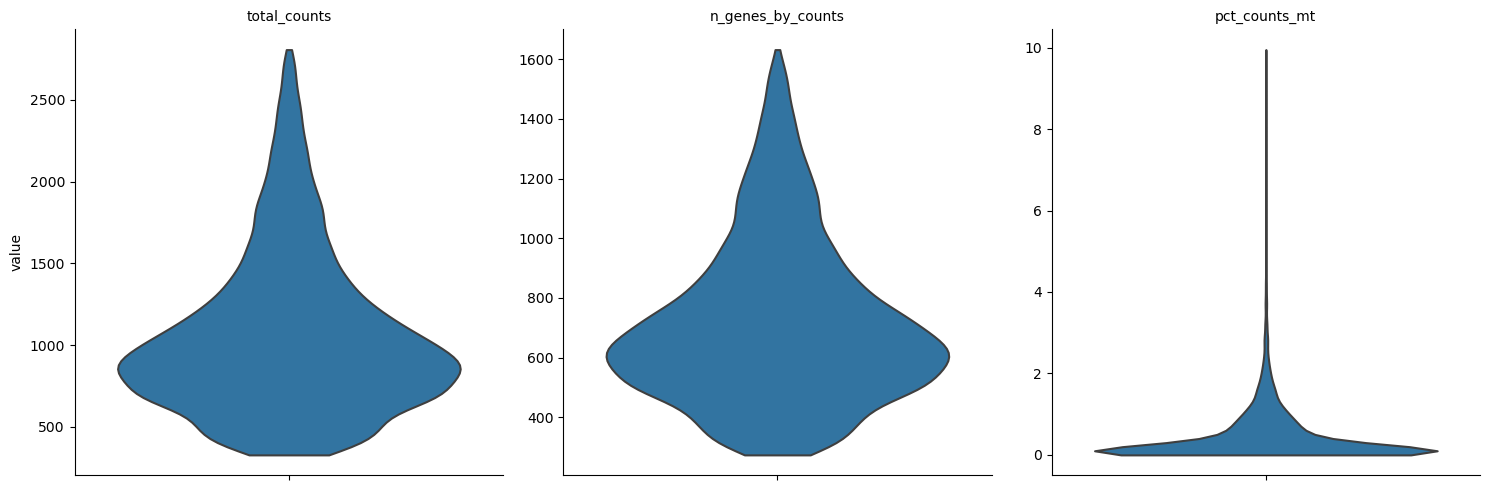

AnnData object with n_obs × n_vars = 11884 × 10850
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [5]:
def plotting_violins(data, output_path='_plots.pdf'):
    data.var['mt'] = data.var.index.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    sc.pl.violin(data, keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save=output_path, stripplot=False)
    return data

plotting_violins(adata)

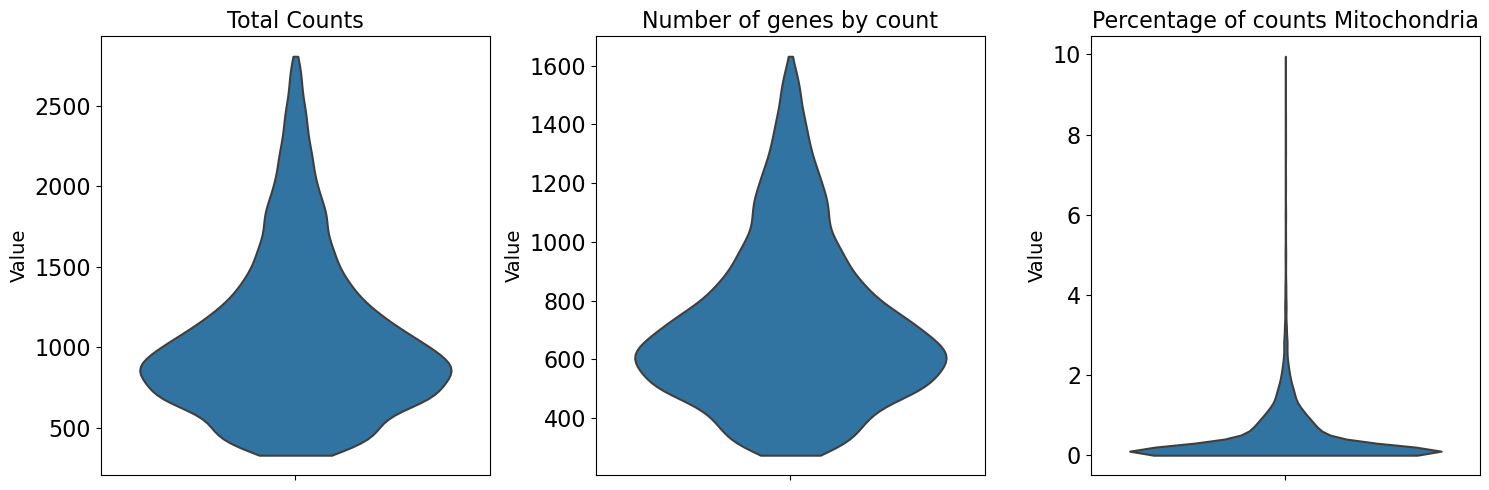

AnnData object with n_obs × n_vars = 11884 × 10850
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [6]:
def plotting_violins_with_titles_subplots(data, output_path='violin_plots.pdf', title_fontsize=16, label_fontsize=16, tick_fontsize=14, axis_label_fontsize=14):
    data.var['mt'] = data.var.index.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    
    keys = ['total_counts', 'n_genes_by_counts', 'pct_counts_mt']
    titles = ['Total Counts', 'Number of genes by count', 'Percentage of counts Mitochondria']
    
    # Setting up the subplot figure
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
    
    for ax, key, title in zip(axs, keys, titles):
        sc.pl.violin(data, keys=key, jitter=0.4, multi_panel=False, show=False, stripplot=False, ax=ax)
        ax.set_title(title, fontsize=title_fontsize)  # Set title font size
        ax.set_xticklabels([], fontsize=tick_fontsize)  # Remove x-axis labels and set tick font size
        ax.tick_params(axis='y', labelsize=label_fontsize)  # Set Y-axis tick label font size
        ax.set_ylabel('Value', fontsize=axis_label_fontsize)  # Set Y-axis label font size
    
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    
    return data

plotting_violins_with_titles_subplots(adata)

In [7]:
def scrubbing(datas):
    
    scrub = scr.Scrublet(datas.X)

    # Perform doublet detection
    scrub_results = scrub.scrub_doublets(min_counts=2, min_cells=3, n_prin_comps=30)

    datas.obs['doublet_scores'] = scrub_results[0]
    datas.obs['predicted_doublets'] = scrub_results[1]

    # Filter out predicted doublets
    datas = datas[datas.obs['predicted_doublets'] == False]

    # Ensure the AnnData object is properly updated
    datas.raw = datas.copy()
    return datas
adata = scrubbing(adata)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.63
Detected doublet rate = 0.6%
Estimated detectable doublet fraction = 32.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.9%
Elapsed time: 6.6 seconds


In [8]:
adata.obs['sample_ID'] = list(map(lambda x: "_".join(x.split("_")[1:]), adata.obs.index))
adata.obs['Disease_status'] = list(map(lambda x: x[0:2], adata.obs['sample_ID']))

In [9]:
adata_raw = adata

In [10]:
def normalisation(data):
    data.raw = data
    sc.pp.normalize_total(data, target_sum=1e4) # Normalises every cell to 10,000 UMI (10,000 unique molecular identifiers)
    data.X.sum(axis=1)
    sc.pp.log1p(data)
    sc.pp.highly_variable_genes(data, n_top_genes= 2000)
    return data

# Makes the numbers more comparable
adata = normalisation(adata)

Failed to generate plot. Check if the plot function is correctly configured to return an Axes object.


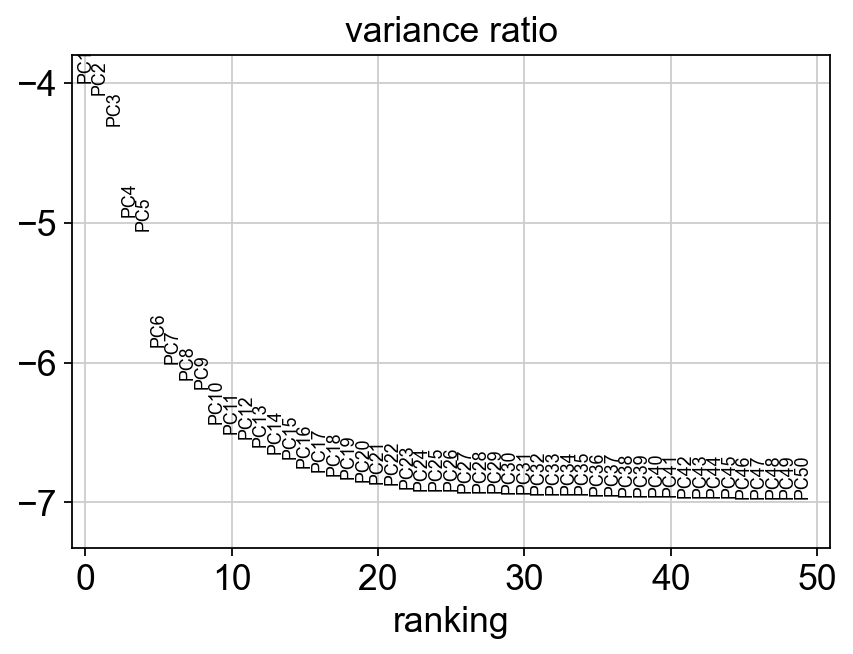

In [11]:
def PCA(data, pcs, output_path='pca_plot.pdf', title_fontsize=20, label_fontsize=16, tick_fontsize=14):
    data = data[:, data.var.highly_variable]
    sc.pp.regress_out(data, ['total_counts', 'pct_counts_mt', 'n_genes_by_counts'])
    sc.pp.scale(data, max_value=10) 
    sc.tl.pca(data, svd_solver='arpack')
    
    # Creating the plot without saving directly
    sc.settings.set_figure_params(dpi_save=300, fontsize=label_fontsize, figsize=(6, 4))
    ax = sc.pl.pca_variance_ratio(data, log=True, n_pcs=pcs, show=False, save=None)
    
    # Now apply font size customizations and save
    if ax is not None:
        ax.set_title('PCA Variance Ratio', fontsize=title_fontsize)
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
        plt.savefig(output_path)
        plt.close()
    else:
        print("Failed to generate plot. Check if the plot function is correctly configured to return an Axes object.")

    data.raw = data
    return data

# Call the function with updated parameters
adata = PCA(adata, 50)

In [12]:
# Commented out for now as it's been calculated and we're using 85%

# # Able to see eigen value for each PC, allows us to workout the the percentage
# # variance that each PC shows.
# d = adata.uns['pca']['variance'] 

# def percentage_variance_calc(data):
#     count = 0
#     n = 0
#     for i in data:
#         n = n + (100*i/sum(data))
#         print(n)
#         count += 1
#         print(count)
# # for loop to workout the percentage variance so I know where to chop it off
# percentage_variance_calc(d)

In [13]:
sc.pp.neighbors(adata, n_pcs= 32) # Forms neighbourhood matrices.
sc.tl.leiden(adata) # Needed to add this in for some reason when i re ran it, but now it works, looks different to before.
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False) # Can remove plot=False if we want to remove the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [14]:
adata.obs['sample_ID'] = list(map(lambda x: "_".join(x.split("_")[1:]), adata.obs.index))
adata.obs['Disease_status'] = list(map(lambda x: x[0:2], adata.obs['sample_ID']))

In [15]:
adata.obs

cell_type  n_genes_by_counts  total_counts  \
AAACCTGGTAGAAAGG_AD5_AD6  Oligodendrocyte                564         760.0   
AAACCTGGTAGCGATG_AD5_AD6  Oligodendrocyte                527         720.0   
AAACCTGTCAGTCAGT_AD5_AD6  Oligodendrocyte                773        1209.0   
AAACCTGTCCAAACAC_AD5_AD6  Oligodendrocyte                615         925.0   
AAACCTGTCCAGTATG_AD5_AD6  Oligodendrocyte                434         562.0   
...                                   ...                ...           ...   
TTTGCGCTCATATCGG_AD1_AD2  Oligodendrocyte                578         809.0   
TTTGGTTCAACTTGAC_AD1_AD2  Oligodendrocyte                307         417.0   
TTTGGTTTCCCAGGTG_AD1_AD2  Oligodendrocyte                359         435.0   
TTTGGTTTCCGTACAA_AD1_AD2  Oligodendrocyte                339         442.0   
TTTGTCATCCACTGGG_AD1_AD2  Oligodendrocyte                603         868.0   

                          total_counts_mt  pct_counts_mt  doublet_scores  \
AAACCTGGTAGAAAGG_AD5_AD6              3.0       0.394737        0.184066   
AAACCTGGTAGCGATG_AD5_AD6             21.0       2.916667        0.092308   
AAACCTGTCAGTCAGT_AD5_AD6             14.0       1.157982        0.195965   
AAACCTGTCCAAACAC_AD5_AD6              1.0       0.108108        0.417790   
AAACCTGTCCAGTATG_AD5_AD6              3.0       0.533808        0.145833   
...                                   ...            ...             ...   
TTTGCGCTCATATCGG_AD1_AD2              9.0       1.112485        0.130901   
TTTGGTTCAACTTGAC_AD1_AD2              3.0       0.719424        0.068296   
TTTGGTTTCCCAGGTG_AD1_AD2              4.0       0.919540        0.054452   
TTTGGTTTCCGTACAA_AD1_AD2              2.0       0.452489        0.465875   
TTTGTCATCCACTGGG_AD1_AD2              6.0       0.691244        0.127503   

                          predicted_doublets sample_ID Disease_status leiden  
AAACCTGGTAGAAAGG_AD5_AD6               False   AD5_AD6             AD      1  
AAACCTGGTAGCGATG_AD5_AD6               False   AD5_AD6             AD      0  
AAACCTGTCAGTCAGT_AD5_AD6               False   AD5_AD6             AD      1  
AAACCTGTCCAAACAC_AD5_AD6               False   AD5_AD6             AD      1  
AAACCTGTCCAGTATG_AD5_AD6               False   AD5_AD6             AD      1  
...                                      ...       ...            ...    ...  
TTTGCGCTCATATCGG_AD1_AD2               False   AD1_AD2             AD      1  
TTTGGTTCAACTTGAC_AD1_AD2               False   AD1_AD2             AD      1  
TTTGGTTTCCCAGGTG_AD1_AD2               False   AD1_AD2             AD      1  
TTTGGTTTCCGTACAA_AD1_AD2               False   AD1_AD2             AD      1  
TTTGTCATCCACTGGG_AD1_AD2               False   AD1_AD2             AD      1  

[11810 rows x 10 columns]

In [16]:
cell_type_disease_counts = adata.obs.groupby(['Disease_status', 'cell_type']).size().unstack(fill_value=0)
cell_type_disease_counts

cell_type       Astrocyte  Endothelial  Microglia  Neuron  OPC  \
Disease_status                                                   
AD                    471           37        172     249  174   
Ct                   1673           61        276     407  897   

cell_type       Oligodendrocyte  
Disease_status                   
AD                         4642  
Ct                         2751

In [17]:
# Keeping this for George but don't actually need it for stats test calculation

sums_by_disease_status = cell_type_disease_counts.sum(axis=1)

# Divide each cell count by the sum to get the proportion
proportions = (cell_type_disease_counts.div(sums_by_disease_status, axis=0))*100

proportions

cell_type       Astrocyte  Endothelial  Microglia    Neuron        OPC  \
Disease_status                                                           
AD               8.198433     0.644038   2.993908  4.334204   3.028721   
Ct              27.584501     1.005771   4.550701  6.710635  14.789777   

cell_type       Oligodendrocyte  
Disease_status                   
AD                    80.800696  
Ct                    45.358615

In [18]:
chi2, p, dof, expected = chi2_contingency(cell_type_disease_counts)
print('Chi-Square Statistic:', chi2, '\nP-value:', p)


Chi-Square Statistic: 1706.3001873581877 
P-value: 0.0


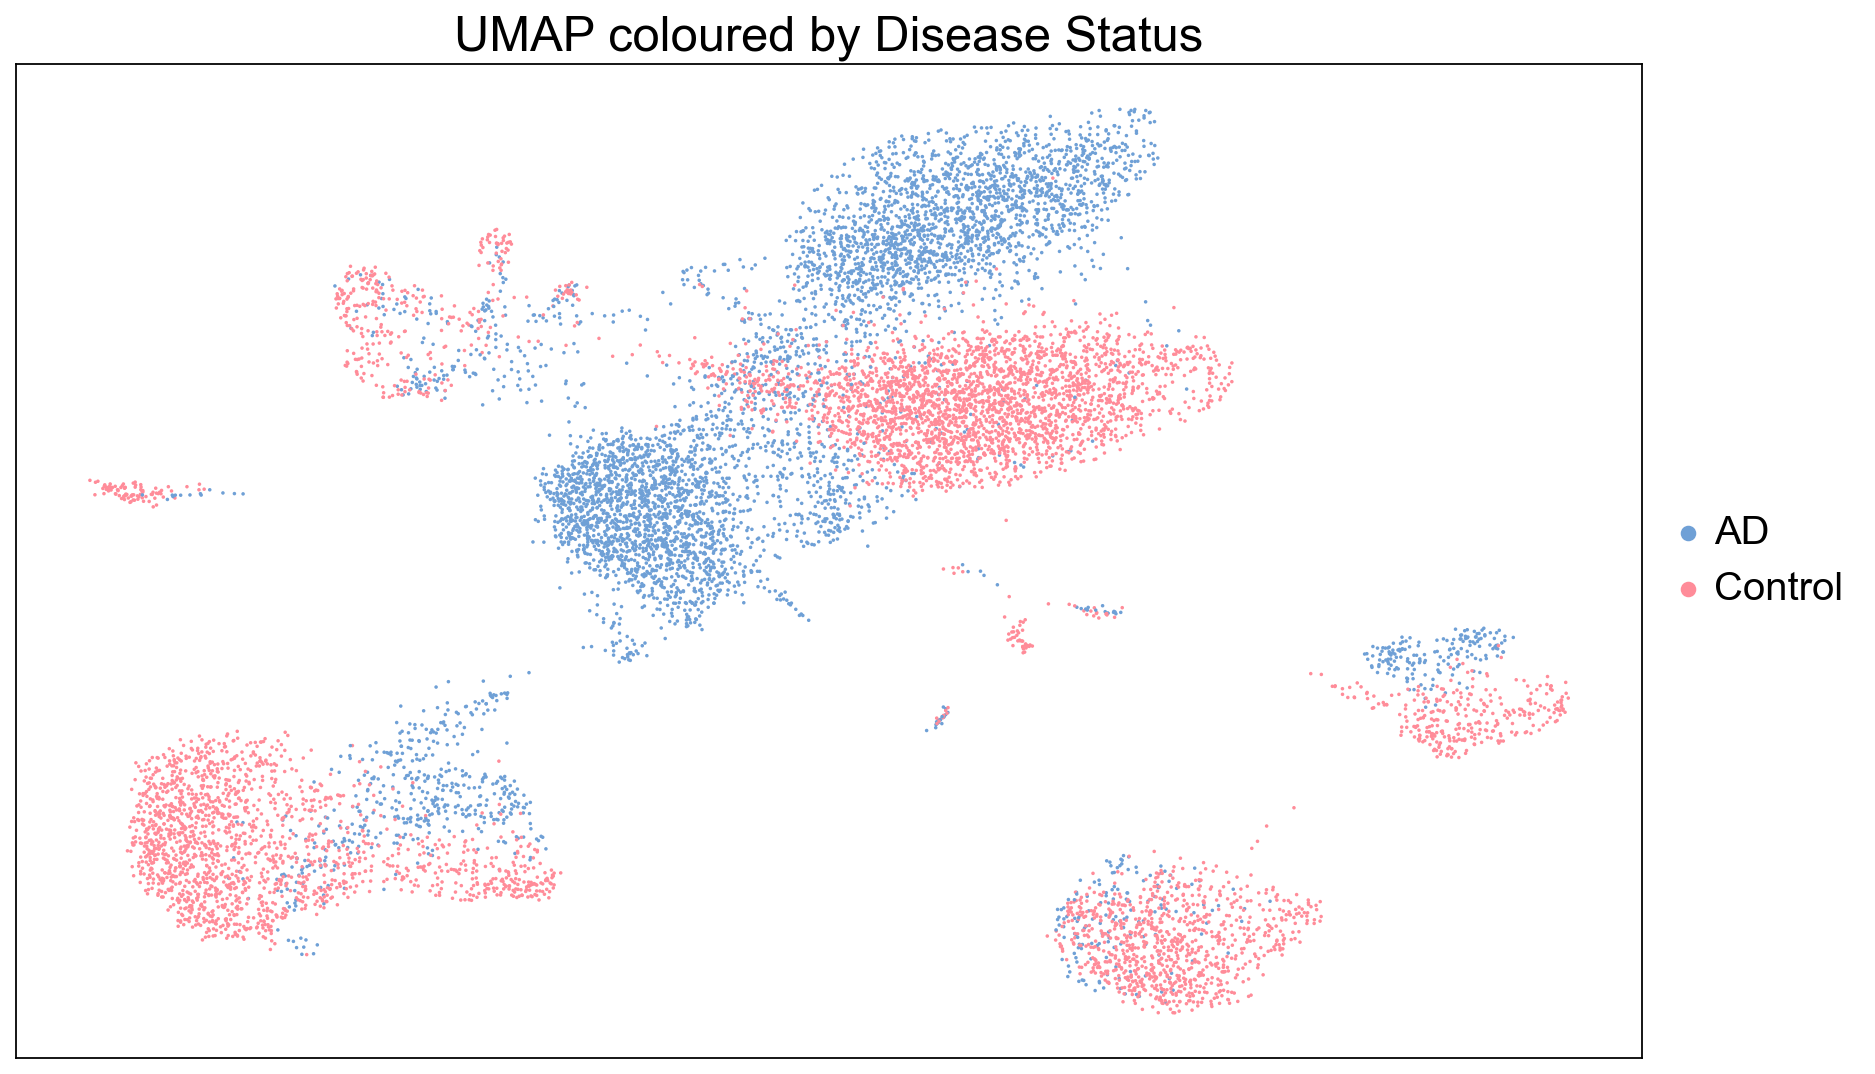

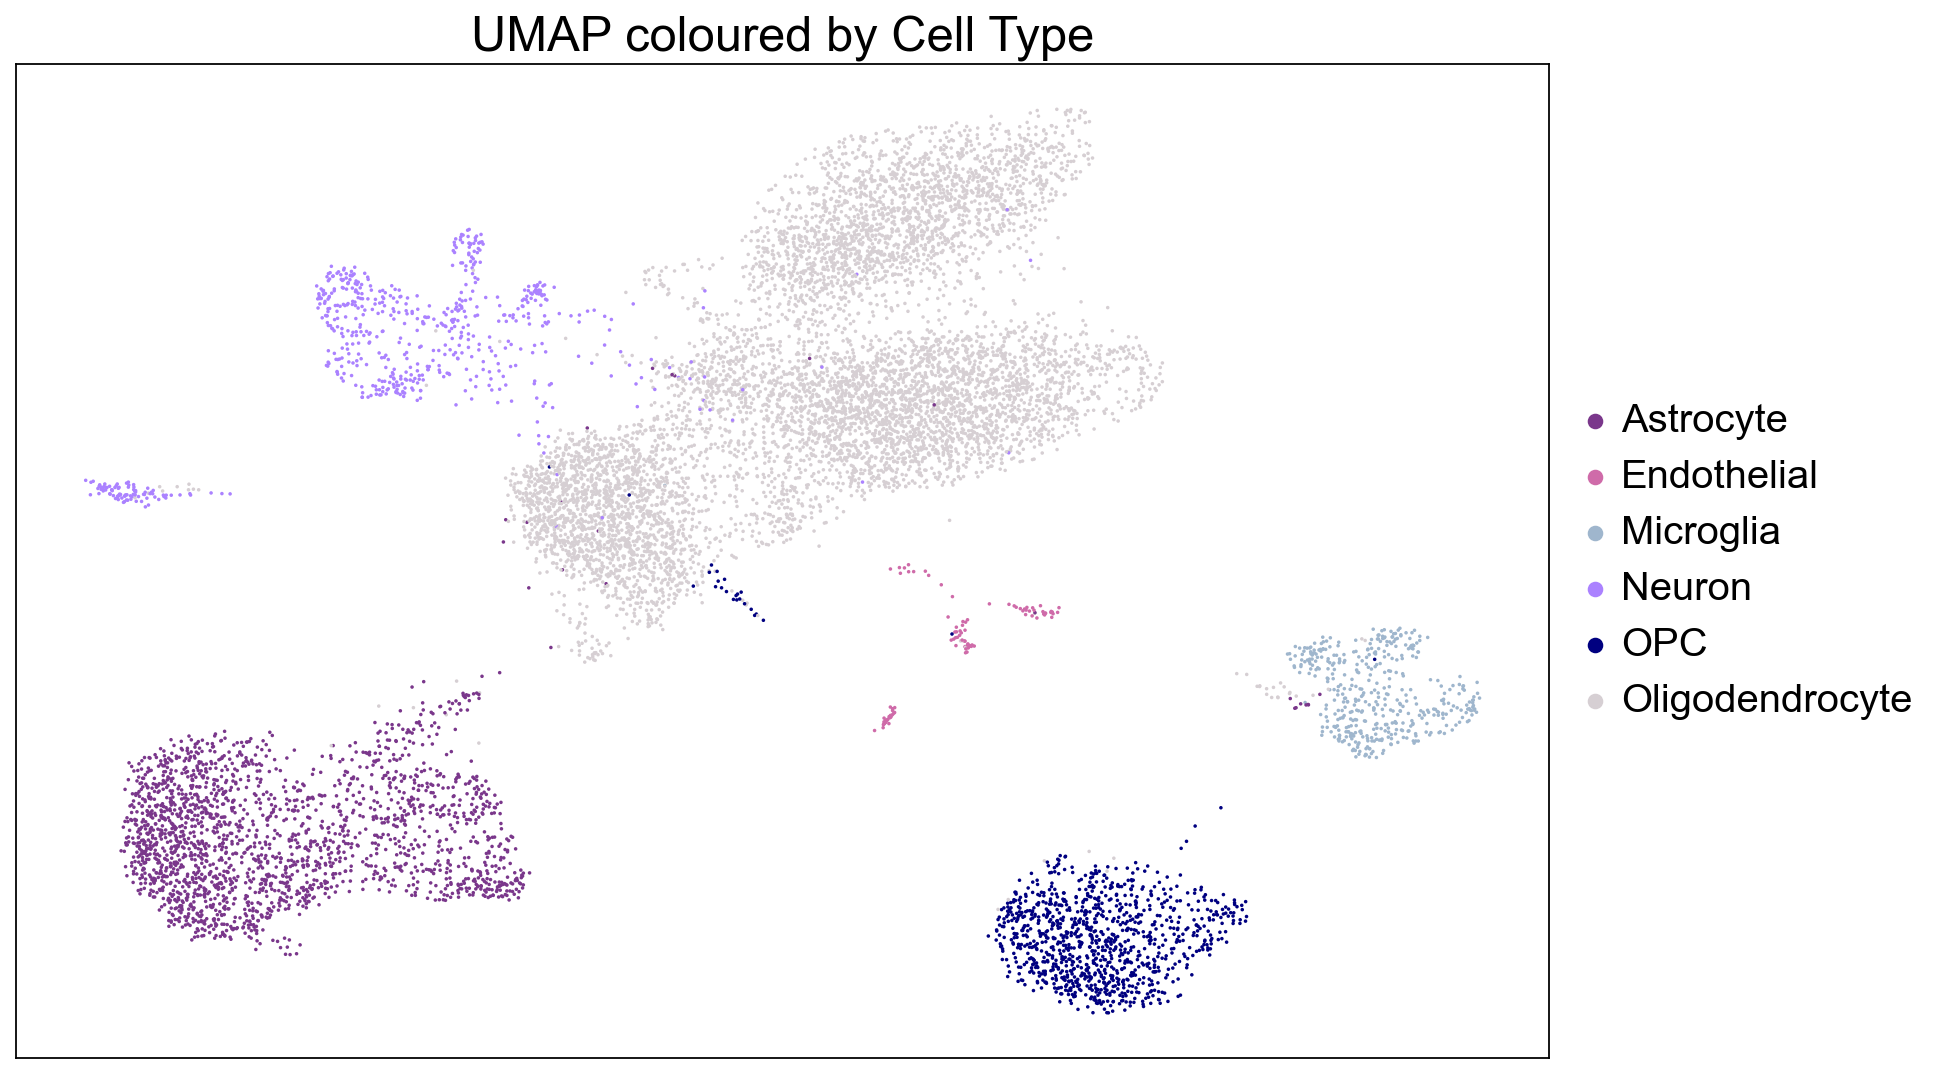

In [99]:
custom_palette = {'AD': '#6FA0D6', 'Ct': '#FF8C99'}
cell_type_palette = {
    'Oligodendrocyte': '#d6cfd3', 'Astrocyte': '#7a378b',
    'Microglia': '#9fb6cd', 'OPC': '#000080',
    'Endothelial': '#cf6ba9', 'Neuron': '#ab82ff'
}

# Plot UMAP for disease status and save it
fig1, ax1 = plt.subplots(figsize=(12, 7))
sc.pl.umap(adata, color='Disease_status', palette=custom_palette, show=False, ax=ax1)
ax1.set_xticks([])  # Remove X axis ticks
ax1.set_yticks([])  # Remove Y axis ticks
ax1.set_xlabel('')  # Remove X axis label
ax1.set_ylabel('')  # Remove Y axis label
plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust layout to make room for the legend

# Modify legend labels and place it outside
handles, labels = ax1.get_legend_handles_labels()
labels[labels.index('Ct')] = 'Control'
ax1.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=18)  # Position legend outside, increase font size
plt.title('UMAP coloured by Disease Status', fontsize=22)  # Increase title font size
plt.tight_layout()

plt.savefig('umap_disease_status.pdf')  # Save the figure

# Plot UMAP for cell_type and save it
fig2, ax2 = plt.subplots(figsize=(12, 7))
sc.pl.umap(adata, color='cell_type', palette=cell_type_palette, show=False, ax=ax2)
ax2.set_xticks([])  # Remove X axis ticks
ax2.set_yticks([])  # Remove Y axis ticks
ax2.set_xlabel('')  # Remove X axis label
ax2.set_ylabel('')  # Remove Y axis label
plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust layout to make room for the legend
plt.title('UMAP coloured by Cell Type', fontsize=22)  # Increase title font size
plt.tight_layout()


# Adjust legend if needed
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=18)

plt.savefig('umap_cell_type.pdf')  # Save the figure with higher resolution

plt.show()

In [20]:
sc.pp.neighbors(adata, n_neighbors= 10)
milo.make_nhoods(adata)

adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]


# Counting the number of each cell type
milo.count_nhoods(adata, sample_col='sample_ID')


# Comparing between the case and control,
milo.DA_nhoods(adata, design= "~ Disease_status")


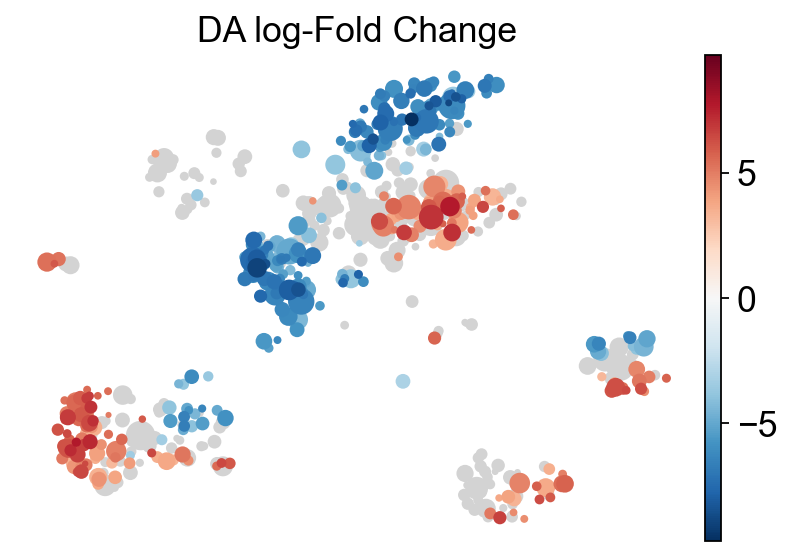

In [21]:
milopy.utils.build_nhood_graph(adata)

# Plotting milo results next to disease status and cell type so I can compare.
milopy.plot.plot_nhood_graph(adata, alpha=0.2, min_size=3, save=(True, '.pdf'))

plt.show()

In [22]:
# Annotating cell_types onto milo data.
milopy.utils.annotate_nhoods(adata, anno_col= 'cell_type')

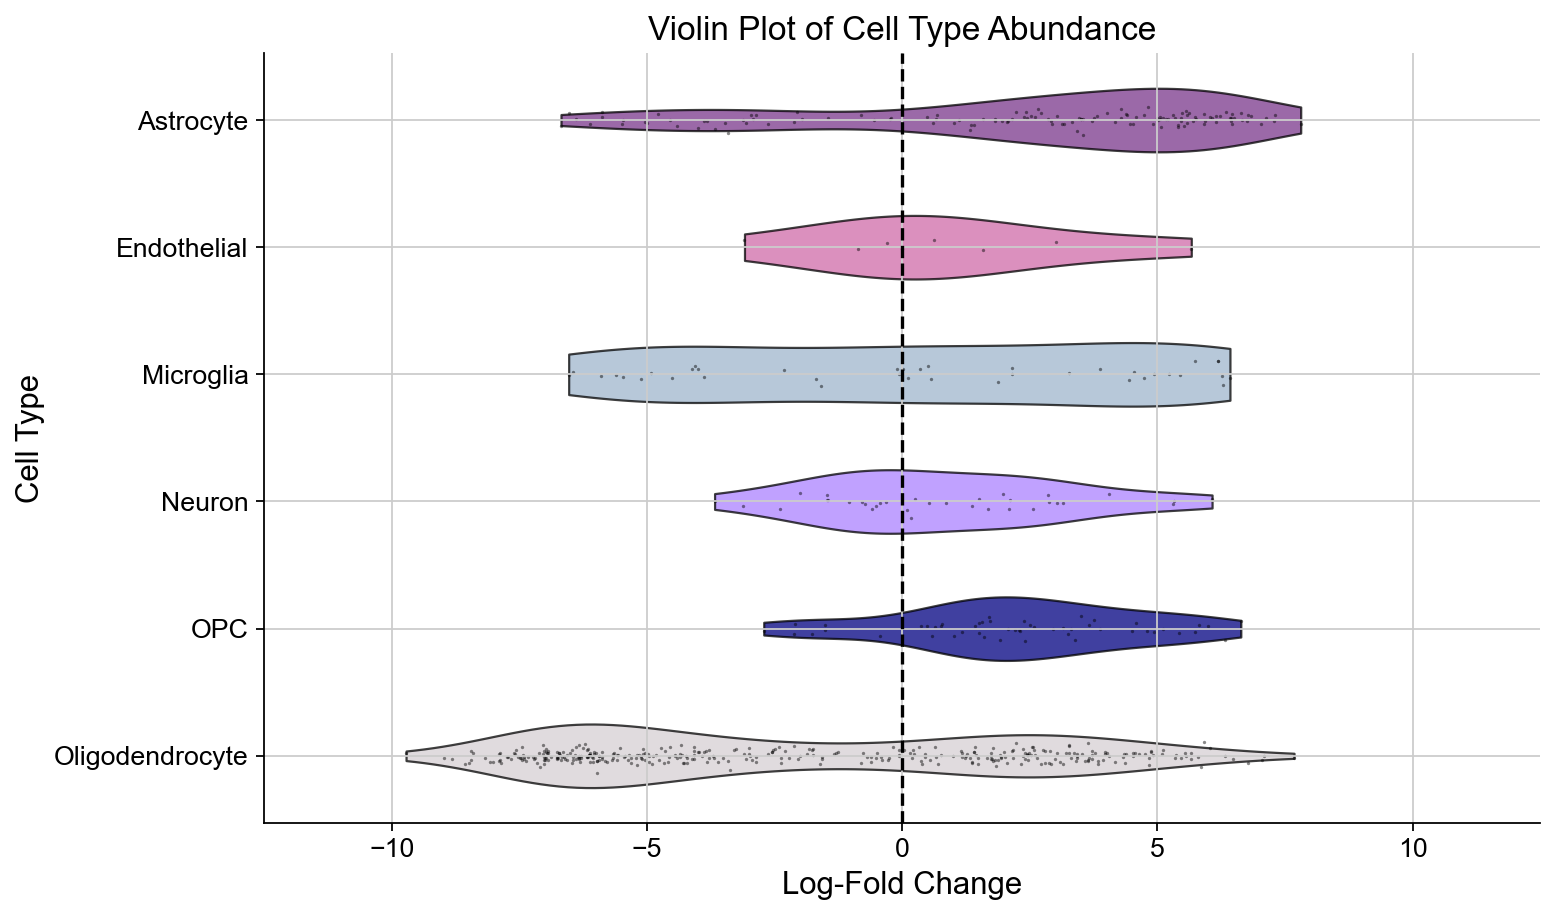

In [23]:
# Extracting logFC values and cell types from nhood adata
logFC = np.array(adata.uns['nhood_adata'].obs['logFC'])
nhood_annotation = np.array(adata.uns['nhood_adata'].obs['nhood_annotation'])

# Find the cell types in the nhood_adata from milo.
groups = np.unique(nhood_annotation)
group_positions = range(1, len(groups) + 1)

# Creating dictionary where keys are groups and values are logFC for that group
grouped_data = {group: logFC[nhood_annotation == group] for group in groups}

# Data needs to be in list of arrays format for violinplot
data = [grouped_data[group] for group in groups]

# Creating figure
fig, ax = plt.subplots(figsize=(10, 6))

violin_parts = ax.violinplot(data, positions=group_positions, vert=False, showmeans=False, showmedians=False, showextrema=False)

# Setting colours to be the same as our umap
colors = ['#7a378b', '#cf6ba9', '#9fb6cd', '#ab82ff', '#000080', '#d6cfd3']

for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans', 'cmedians', 'cquantiles'):
    vp = violin_parts.get(partname)
    if vp is not None:
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

# If you want to set individual colors for each violin, you can do it like this:
for vp, color in zip(violin_parts['bodies'], colors):
    vp.set_facecolor(color)
    vp.set_edgecolor('black')
    vp.set_alpha(0.75)

for i, group in enumerate(groups):
    scatter_data = grouped_data[group]
    jitter = np.random.normal(0, 0.04, size=len(scatter_data))
    ax.scatter(scatter_data, np.repeat(group_positions[i], len(scatter_data)) + jitter, alpha=0.45, color='black', s=0.25)

# cell type as ticks for y axis
ax.set_yticks(range(1, len(groups) + 1))
ax.set_yticklabels(groups)

# Set the labels for the axes
ax.set_ylabel('Cell Type', fontsize=16)
ax.set_xlabel('Log-Fold Change', fontsize=16)

# setting limits for LogFC
ax.set_xlim(-12.5, 12.5)

# vertical dashed line to show LogFC 0 
ax.axvline(x=0, color='black', linestyle='--')

# Remove top and right spines so that its open
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()

# Set title fontsize
plt.title('Violin Plot of Cell Type Abundance', fontsize=15)

# Set label fontsize
plt.xlabel('Log-Fold Change', fontsize=14)
plt.ylabel('Cell Type', fontsize=14)

# Set tick fontsize
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the figure
plt.savefig('Violin_of_celltype_abundance_matplotlib.pdf')

# Show the plot
plt.show()      

In [24]:
# Differential expression
adata_oligo = adata[adata.obs['cell_type'] == 'Oligodendrocyte']
sc.tl.rank_genes_groups(adata_oligo, 'Disease_status')
result_oligo = sc.get.rank_genes_groups_df(adata_oligo, group='AD')

adata_astro = adata[adata.obs['cell_type'] == 'Astrocyte']
sc.tl.rank_genes_groups(adata_astro, 'Disease_status')
result_astro = sc.get.rank_genes_groups_df(adata_astro, group='AD')

adata_oligo_ct = adata[adata.obs['cell_type'] == 'Oligodendrocyte']
sc.tl.rank_genes_groups(adata_oligo_ct, 'Disease_status')
result_oligo_ct = sc.get.rank_genes_groups_df(adata_oligo_ct, group='Ct')

adata_astro_ct = adata[adata.obs['cell_type'] == 'Astrocyte']
sc.tl.rank_genes_groups(adata_astro_ct, 'Disease_status')
result_astro_ct = sc.get.rank_genes_groups_df(adata_astro_ct, group='Ct')




In [25]:
# Making volcano plots that have the gene name labelled if there is difference > |7|

LOG_FOLD_CHANGE = 1.5
FDR = 0.1

def volcano_plot(cell_type, title, filename, ax=None):
    result = cell_type.copy()
    result['genes'] = adata.var_names
    
    result["-logQ"] = -np.log10(result["pvals"].astype("float"))  # Note: Use log10 for Q-values
    lowqval_de = result.loc[abs(result["logfoldchanges"]) > LOG_FOLD_CHANGE]
    other_de = result.loc[abs(result["logfoldchanges"]) <= LOG_FOLD_CHANGE]

    if ax is None:
        fig, ax = plt.subplots()

    # Color code based on 'Disease_status'
    scatter_ct = sns.scatterplot(
        x=other_de["logfoldchanges"],
        y=other_de["-logQ"],
        s=6, color='#FF8C99',  # Use red for 'Ct'
        ax=ax,
    )
    scatter_ad = sns.scatterplot(
        x=lowqval_de["logfoldchanges"],
        y=lowqval_de["-logQ"],
        s=6, color='#6FA0D6',  # Use blue for 'AD'
        ax=ax,
    )
    ax.set_xlabel("log2 FC", fontsize=14)
    ax.set_ylabel("-log Q-value", fontsize=14)
    
    if title is None:
        title = "custom DE"
    plt.ylim(0, 12.5)
    plt.title(title, fontsize=16)
    
    # Label genes with logFC less than -7 or greater than 7
    for i, row in result.iterrows():
        if abs(row['logfoldchanges']) > 7:
            ax.annotate(row['genes'],  # Using gene column i added to result df
                        xy=(row['logfoldchanges'], row['-logQ']),
                        xytext=(5, 2),
                        textcoords='offset points',
                        ha='right',
                        va='bottom',
                        fontsize=8)
    
    plt.savefig(filename)
    plt.show()

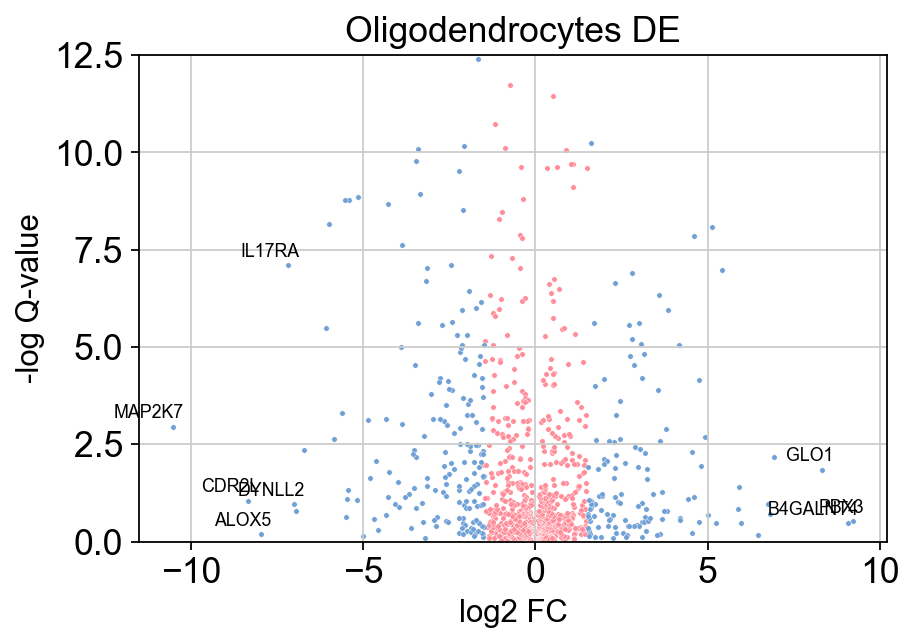

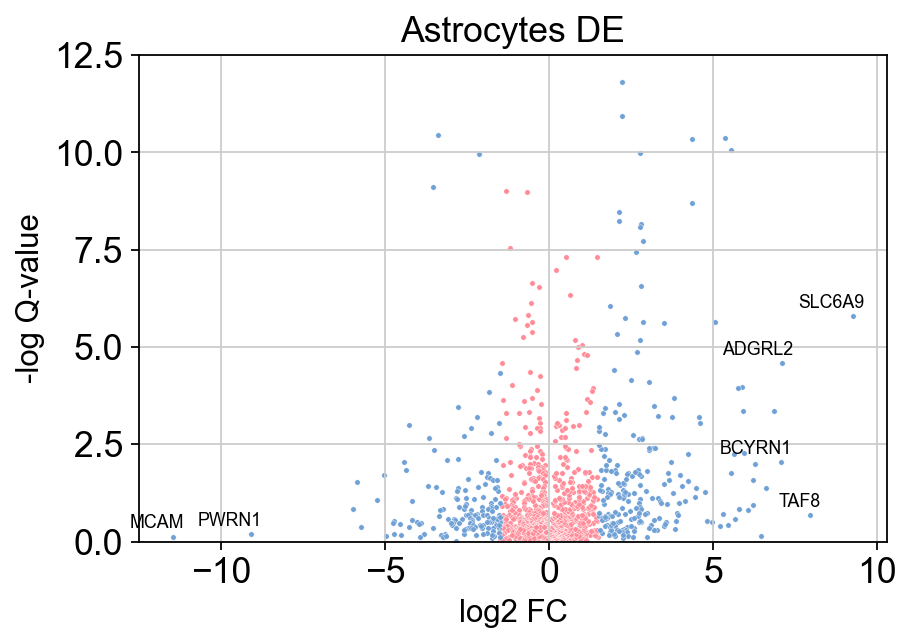

In [26]:
volcano_plot(result_oligo, 'Oligodendrocytes DE', 'Oligodendrocyte_DE.pdf')
volcano_plot(result_astro, 'Astrocytes DE','Astrocyte_DE.pdf')

Lineages: [Lineage[4, 1, 2], Lineage[4, 1, 5, 0], Lineage[4, 1, 5, 3]]


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Reversing from leaf to root
Averaging branch @5 with lineages: [1, 2] [<pcurvepy2.pcurve.PrincipalCurve object at 0x371256590>, <pcurvepy2.pcurve.PrincipalCurve object at 0x371b0db90>]
Averaging branch @1 with lineages: [0, 1, 2] [<pcurvepy2.pcurve.PrincipalCurve object at 0x371419e10>, <pcurvepy2.pcurve.PrincipalCurve object at 0x3713741d0>]
Shrinking branch @1 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x371419e10>, <pcurvepy2.pcurve.PrincipalCurve object at 0x3713741d0>]
Shrinking branch @5 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x371256590>, <pcurvepy2.pcurve.PrincipalCurve object at 0x371b0db90>]


100%|█████████████████████████████████████████████| 1/1 [01:21<00:00, 81.89s/it]


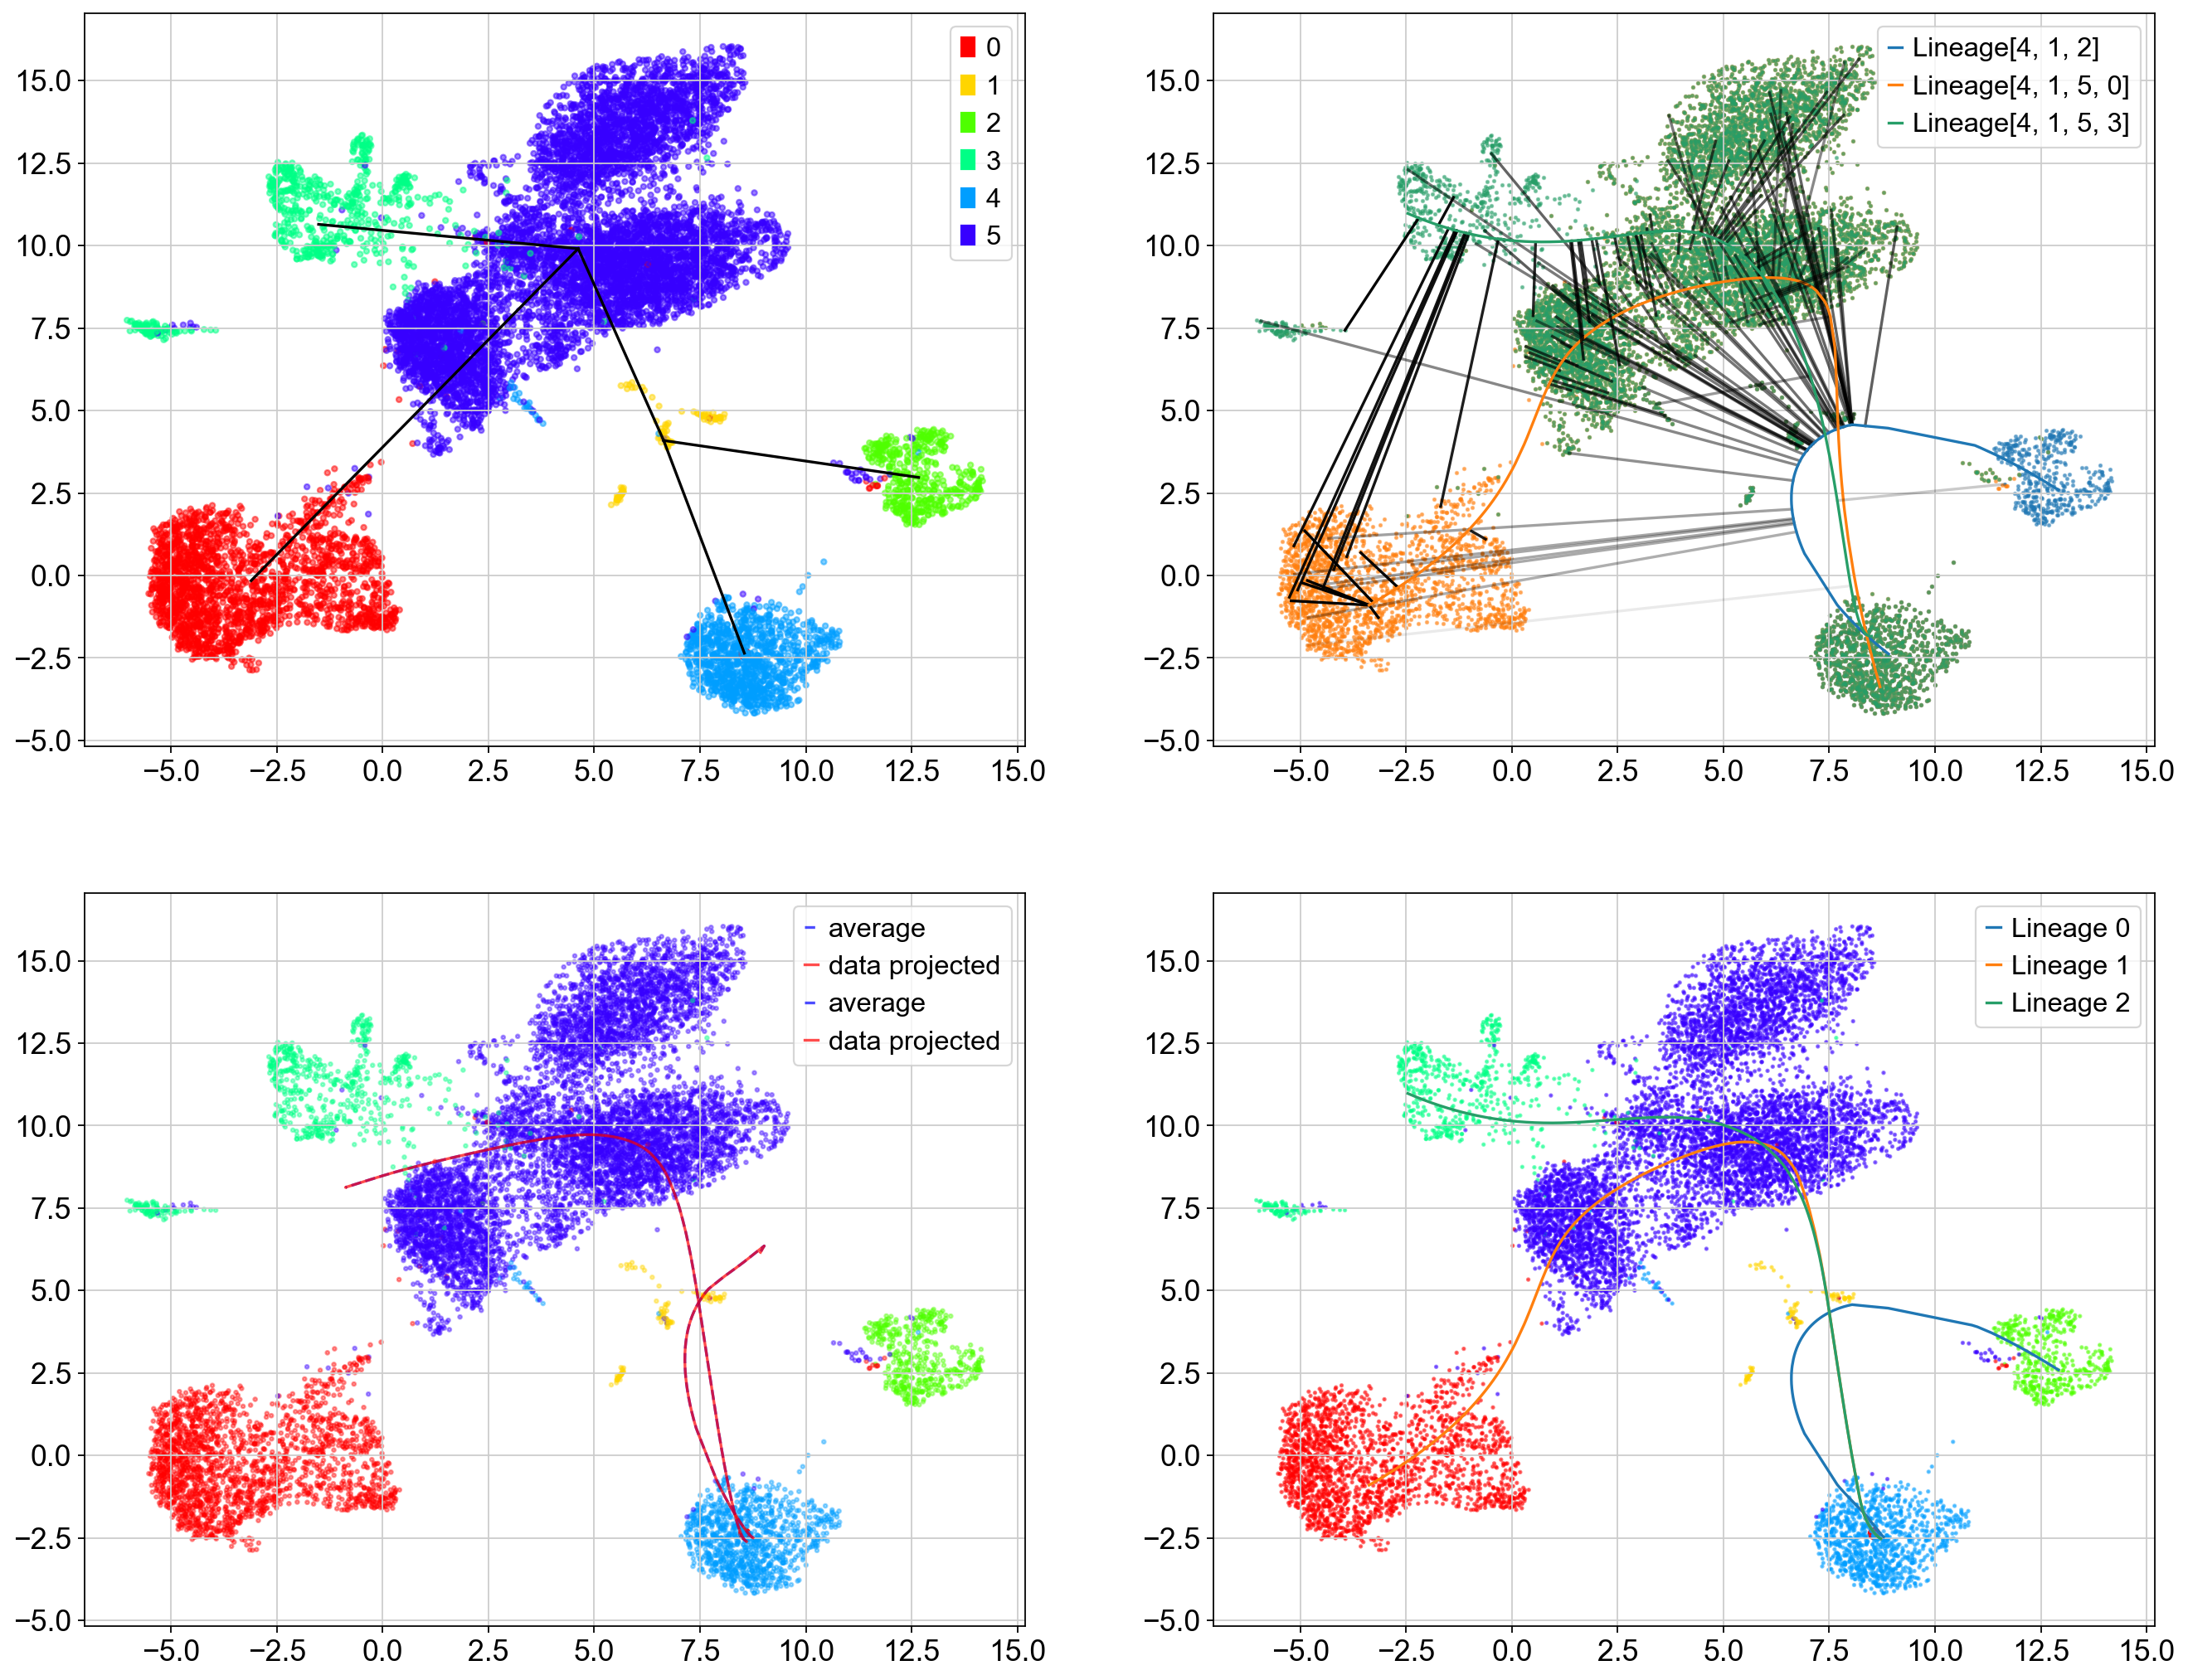

In [27]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)
# plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

slingshot = Slingshot(adata, celltype_key="cell_type", start_node= 4, obsm_key="X_umap", debug_level='verbose')
slingshot.fit(num_epochs=1, debug_axes=axes)



In [28]:
#Getting the psuedotime
pseudotime = slingshot.unified_pseudotime

# Adding the pseudotime that I just accessed to the adata dataframe, so that I can compare between CT and AD
adata.obs['pseudotime'] = pseudotime

In [29]:
def trajectories(axis):
    for pc in slingshot.curves:
        curve_points = pc.points
        axis.plot(pc.points[:, 0], pc.points[:, 1], color='black', lw=0.75)  # Plot on the first subplot

# See if George can get the arrow to work, not sure where I'm going wrong, maybe need to do a forloop?
    if len(curve_points) > 1:
        start_point = curve_points[-2]
        end_point = curve_points[-1]
        
        arrow = FancyArrowPatch(posA= start_point, posB= end_point,
                               arrowstyle= '->', mutation_scale=50,
                               color='black', lw=1)
        axis.add_patch(arrow)

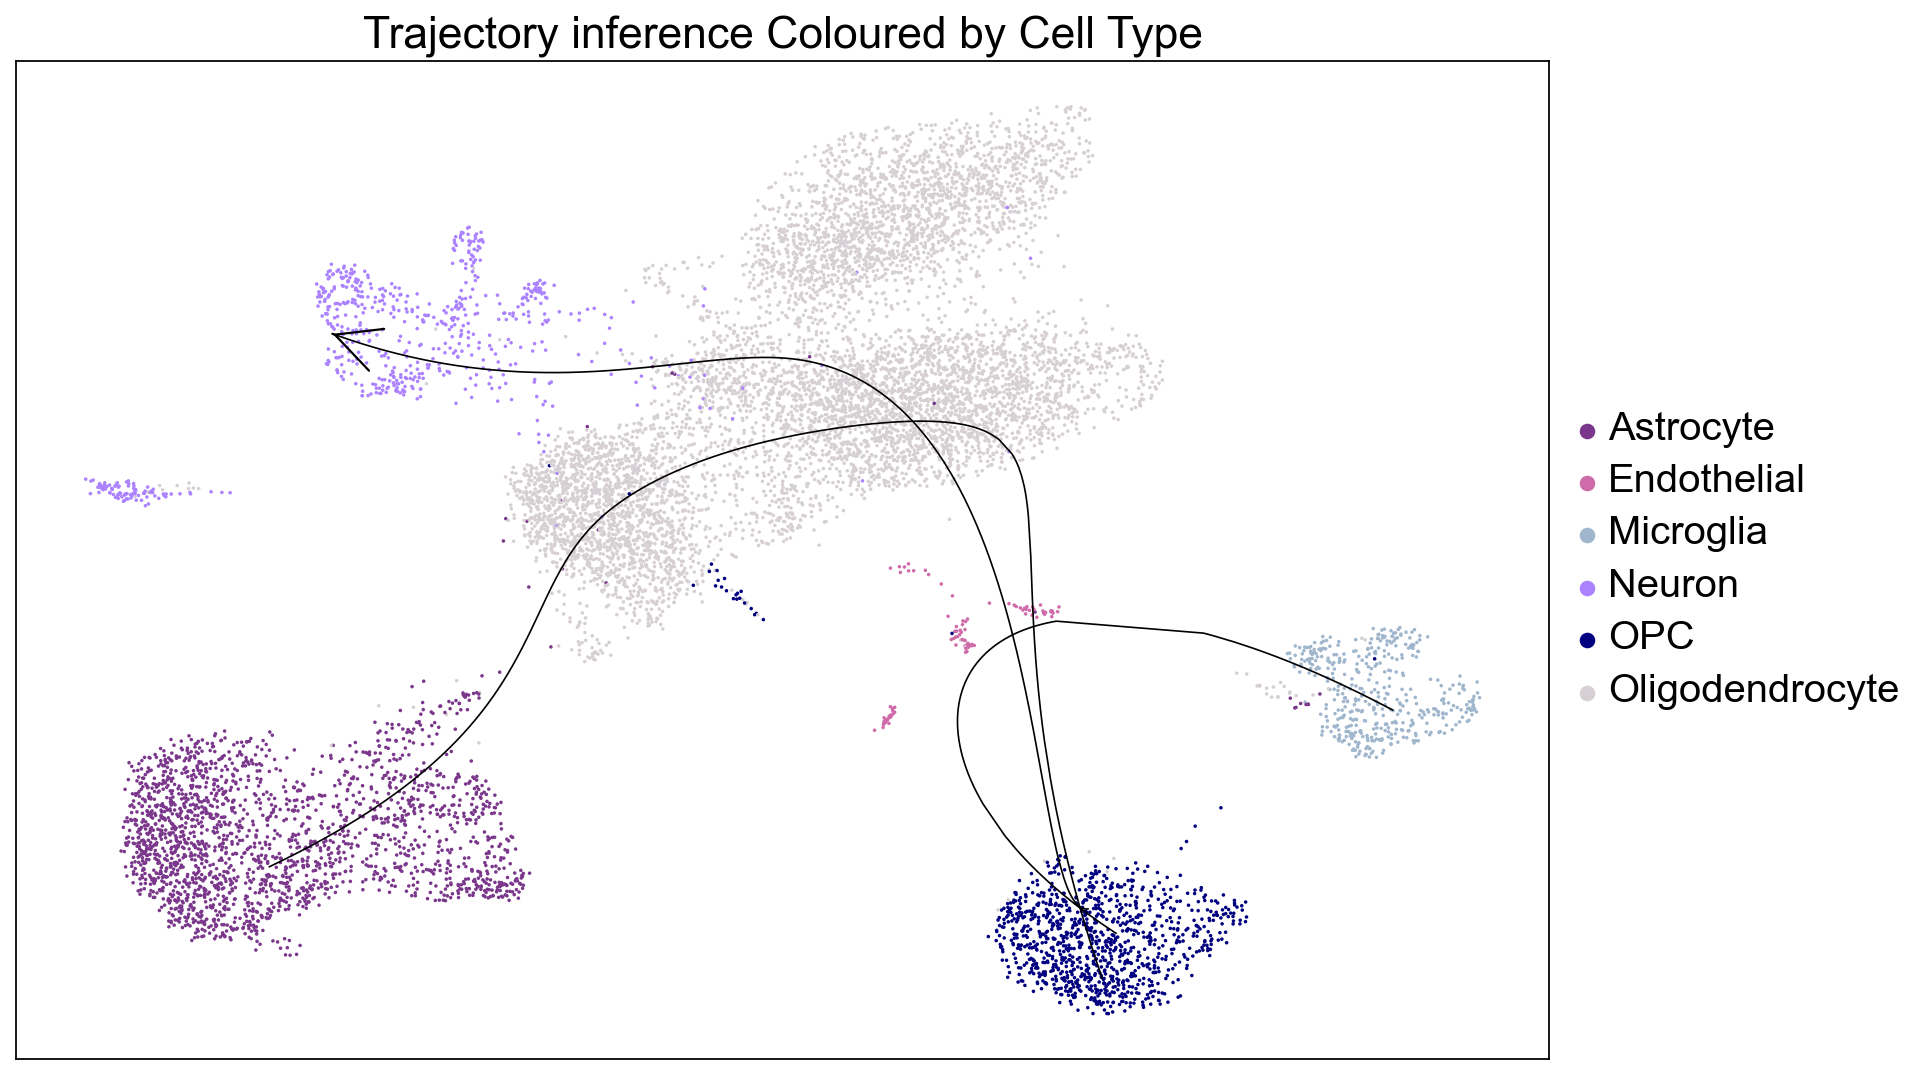

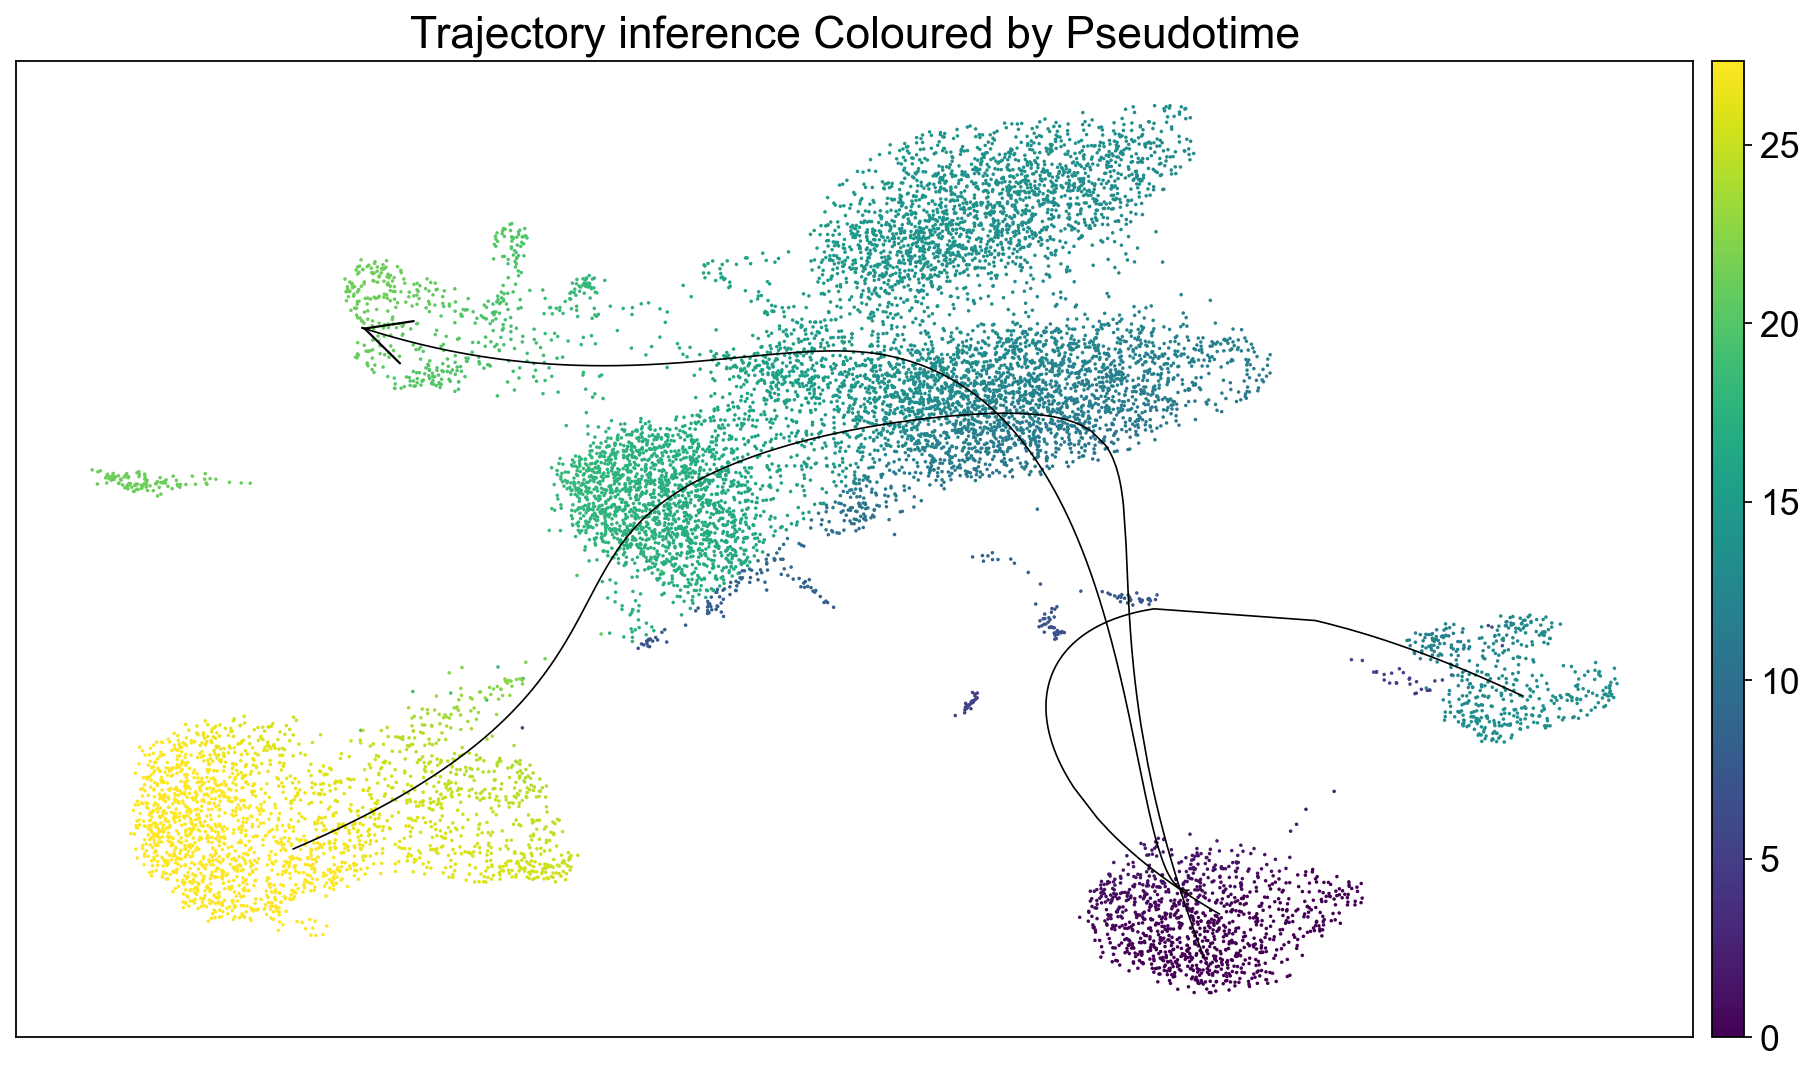

In [100]:
fig1, ax1 = plt.subplots(figsize=(12, 7))
sc.pl.umap(adata, color='cell_type', show=False, ax=ax1)
plt.title('Trajectory inference Coloured by Cell Type', fontsize=20)
trajectories(ax1)
ax1.set_xticks([])  # Remove X axis ticks
ax1.set_yticks([])  # Remove Y axis ticks
ax1.set_xlabel('')  # Remove X axis label
ax1.set_ylabel('')  # Remove Y axis label
plt.tight_layout()

# Accessing the legend object and setting the fontsize
legend = ax1.get_legend()
for text in legend.get_texts():
    text.set_fontsize(18)
plt.savefig('slingshot_with_celltype.pdf')

# Plot the UMAP colored by pseudotime and save the figure
fig2, ax2 = plt.subplots(figsize=(12, 7))
sc.pl.umap(adata, color='pseudotime', show=False, ax=ax2)
trajectories(ax2)
plt.title('Trajectory inference Coloured by Pseudotime', fontsize=20)
ax2.set_xticks([])  # Remove X axis ticks
ax2.set_yticks([])  # Remove Y axis ticks
ax2.set_xlabel('')  # Remove X axis label
ax2.set_ylabel('')  # Remove Y axis label
plt.tight_layout()
plt.savefig('Slingshot_with_pseudotime.pdf')

# Show the figures if needed
plt.show()


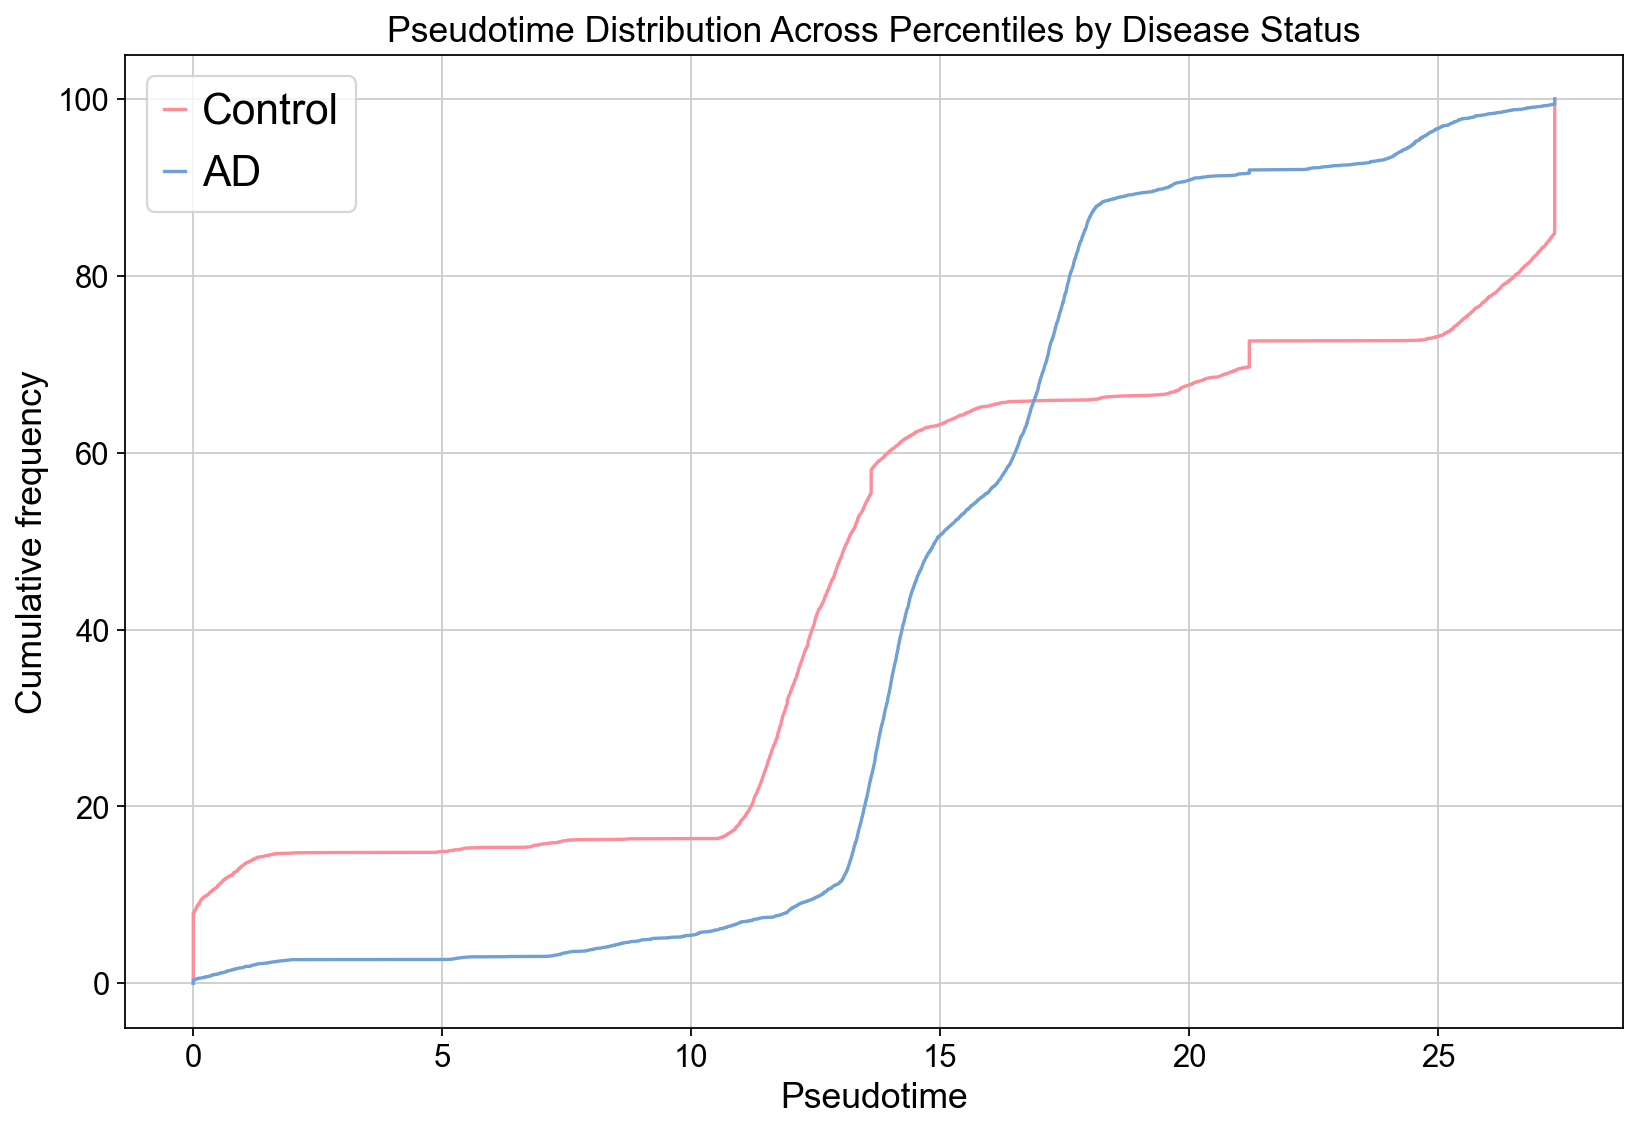

In [31]:
# Putting the pseudotime in order for each Disease_status
pseudotime_ct = np.sort(adata.obs.loc[adata.obs['Disease_status'] == 'Ct', 'pseudotime'])
pseudotime_ad = np.sort(adata.obs.loc[adata.obs['Disease_status'] == 'AD', 'pseudotime'])

# Calculating the percentile ranks for each Disease_status directly
percentile_ranks_ct = np.linspace(0, 100, len(pseudotime_ct))
percentile_ranks_ad = np.linspace(0, 100, len(pseudotime_ad))

# Plotting our percentile ranks against pseudotime for both AD and CT
plt.figure(figsize=(12, 8))
plt.plot(pseudotime_ct, percentile_ranks_ct, label='Control', color='#FF8C99')
plt.plot(pseudotime_ad, percentile_ranks_ad, label='AD', color='#6FA0D6')
plt.xlabel('Pseudotime', fontsize=16)
plt.ylabel('Cumulative frequency', fontsize=16)
plt.title('Pseudotime Distribution Across Percentiles by Disease Status', fontsize=16)
plt.legend(loc='upper left', fontsize='large')
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('percentage_through_differentiation.pdf')
plt.show()

In [32]:
# Doing a stats using interpolation to estimate values, might not be as accurate so will do another

common_percentiles = np.linspace(0,100, max(len(pseudotime_ct), len(pseudotime_ad)))

# Creating interpolation functions for both
interp_func_ct = interp1d(percentile_ranks_ct, pseudotime_ct, bounds_error=False, fill_value='extrapolate')
interp_func_ad = interp1d(percentile_ranks_ad, pseudotime_ad, bounds_error=False, fill_value='extrapolate')

# Interpolating the pseudotimes to common percentiles
interp_pseudotime_ct = interp_func_ct(common_percentiles)
interp_pseudotime_ad = interp_func_ad(common_percentiles)

# Calculating the cumulative frequency difference
cumulative_frequency_difference = interp_pseudotime_ct - interp_pseudotime_ad

overall_difference = sum(cumulative_frequency_difference)
cumulative_frequency_difference
overall_difference

-2243.489078982947

In [33]:
def area(pseudotime_ct, pseudotime_ad):
    # Doing a stats using interpolation to estimate values, might not be as accurate so will do another

    common_percentiles = np.linspace(0,100, max(len(pseudotime_ct), len(pseudotime_ad)))

    # Creating interpolation functions for both
    interp_func_ct = interp1d(percentile_ranks_ct, pseudotime_ct, bounds_error=False, fill_value='extrapolate')
    interp_func_ad = interp1d(percentile_ranks_ad, pseudotime_ad, bounds_error=False, fill_value='extrapolate')

    # Interpolating the pseudotimes to common percentiles
    interp_pseudotime_ct = interp_func_ct(common_percentiles)
    interp_pseudotime_ad = interp_func_ad(common_percentiles)

    # Calculating the cumulative frequency difference
    cumulative_frequency_difference = interp_pseudotime_ct - interp_pseudotime_ad

    overall_difference = sum(cumulative_frequency_difference)
    return overall_difference
    

In [34]:
w_stat, p_value = wilcoxon(cumulative_frequency_difference)
print('Wilcoxon rank test statistic:', w_stat, '\nP-value:', p_value)

Wilcoxon rank test statistic: 8187366.0 
P-value: 5.192542871543846e-10


In [35]:
combined_data = np.concatenate((pseudotime_ct, pseudotime_ad))

# Calculate the original difference in means
original_diff = np.mean(pseudotime_ct) - np.mean(pseudotime_ad)

# Initialize the permutation test
n_permutations = 10000
count = 0

# Permutation loop to shuffle it?
for _ in range(n_permutations):
    # Shuffle the combined data
    np.random.shuffle(combined_data)
    
    # Split the permuted data into new groups
    permuted_ct = combined_data[:len(pseudotime_ct)]
    permuted_ad = combined_data[len(pseudotime_ct):]
    
    # Calculate the test statistic for the permuted groups
    permuted_diff = np.mean(permuted_ct) - np.mean(permuted_ad)
    
    # If the permuted difference is as extreme as the original difference, increment count
    if np.abs(permuted_diff) >= np.abs(original_diff):
        count += 1

# Calculate the p-value
p_value = count / n_permutations

print('Permutation test p-value:', p_value)

Permutation test p-value: 0.0038


In [36]:
gene_list = adata.var_names
glist = gene_list.str.strip().to_list()


In [37]:
def cell_type_frame(adata, cell_type):
    # Filter the adata to only include the specified cell_type
    mask = adata.obs['cell_type'] == cell_type
    # Make sure to index the .obs and .X (or relevant data) with the same mask
    filtered_data = adata[mask, :]
    # Convert the filtered data to a DataFrame
    frame = pd.DataFrame(filtered_data.X, index=filtered_data.obs_names, columns=filtered_data.var_names)
    return frame

def disease_status_for_celltype(adata, cell_type):
    # Filter the adata to only include the specified cell_type
    mask = adata.obs['cell_type'] == cell_type
    # Apply the mask and get the 'Disease_status' column
    result = adata.obs.loc[mask, 'Disease_status']
    return result

In [38]:
astrocyte_frame = cell_type_frame(adata, 'Astrocyte').T
astrocyte_disease_status = disease_status_for_celltype(adata, 'Astrocyte')
oligodendrocyte_frame = cell_type_frame(adata, 'Oligodendrocyte').T
oligodendrocyte_disease_status = disease_status_for_celltype(adata, 'Oligodendrocyte')

In [39]:
def running_gseapy(cell_frame, disease_status):
    result = gp.gsea(data=cell_frame, # row -> genes, column-> samples
            gene_sets='MSigDB_Hallmark_2020',
            cls=disease_status,
            outdir=None,
            method='s2n', # signal_to_noise
            threads= 16)
    return result

In [40]:
result_astro = running_gseapy(astrocyte_frame, astrocyte_disease_status)
result_oligo = running_gseapy(oligodendrocyte_frame, oligodendrocyte_disease_status)

In [41]:
result_astro.res2d.head(10)

Name                               Term        ES       NES NOM p-val  \
0  gsea                         Myogenesis  0.671936  2.351312       0.0   
1  gsea                         Glycolysis  0.592516   2.14532       0.0   
2  gsea                        E2F Targets  0.599256  1.921587  0.004598   
3  gsea             Estrogen Response Late  0.575752  1.916886       0.0   
4  gsea  Epithelial Mesenchymal Transition  0.497753  1.906439       0.0   
5  gsea            Estrogen Response Early   0.58383   1.84187  0.006424   
6  gsea                    Apical Junction  0.491287  1.790166  0.005141   
7  gsea                            Hypoxia  0.468971  1.745643  0.004695   
8  gsea           IL-6/JAK/STAT3 Signaling  0.537771  1.679464  0.028169   
9  gsea                  KRAS Signaling Dn -0.522234 -1.664428  0.013605   

  FDR q-val FWER p-val  Tag %  Gene %  \
0       0.0        0.0  14/32  10.70%   
1  0.001014      0.001  16/33  21.50%   
2    0.0142       0.02  13/21  29.90%   
3  0.011664      0.022   8/23  13.80%   
4  0.010548      0.025  25/43  34.65%   
5  0.018933      0.053   9/20  19.45%   
6  0.023183      0.074  12/32  29.10%   
7  0.027132      0.097  18/38  26.55%   
8  0.041698      0.162   7/18  20.05%   
9  0.052744      0.209   8/23  14.80%   

                                          Lead_genes  
0  ITGB4;IGFBP7;AEBP1;SORBS1;APLNR;DTNA;PLXNB2;CR...  
1  VCAN;CD44;ANGPTL4;IRS2;CHST6;GLCE;PLOD1;ENO2;I...  
2  NOP56;CCP110;SHMT1;RFC3;TBRG4;DNMT1;HMGA1;CSE1...  
3      CD44;FKBP5;ZFP36;HSPB8;FOS;IL6ST;SLC7A5;ITPK1  
4  VCAN;CD44;MATN2;SPP1;FLNA;SLC6A8;VIM;PLOD3;COL...  
5  CD44;FKBP5;HSPB8;FOS;IL6ST;SLC7A5;ITPK1;KAZN;F...  
6  ITGB4;VCAN;PKD1;BAIAP2;TAOK2;BMP1;NEXN;ACTN4;M...  
7  ZFP36;ANGPTL4;IRS2;DTNA;FOS;DUSP1;EFNA1;ENO2;C...  
8        CD44;TNFRSF1A;IL6ST;CSF1;STAT2;IL13RA1;CD14  
9    TENM2;FGFR3;NR4A2;GRID2;SNN;BTG2;KCNMB1;SLC30A3

In [42]:
def plotting_gseapy(result, number, title, graph_name):
    terms = result.res2d['Term'].head(number)
    NES = result.res2d['NES'].sort_values(ascending=False).head(number)
    FWERP = result.res2d['FWER p-val'].head(number)
    
    colors = ['skyblue' if p < 0.05 else '#FF8C99' for p in FWERP]
    skyblue_patch = mpatches.Patch(color='skyblue', label='p < 0.05')
    red_patch = mpatches.Patch(color='#FF8C99', label='p > 0.05')
    
    
    plt.figure(figsize=(10, 8))
    plt.barh(terms, NES, color= colors)
    plt.xlabel('Normalised Enrichment Score (NES)')
    plt.ylabel('Terms')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to display terms from top to bottom
    plt.legend(handles=[skyblue_patch, red_patch], loc='best')
    plt.tight_layout()
    plt.savefig(graph_name)
    plt.show()

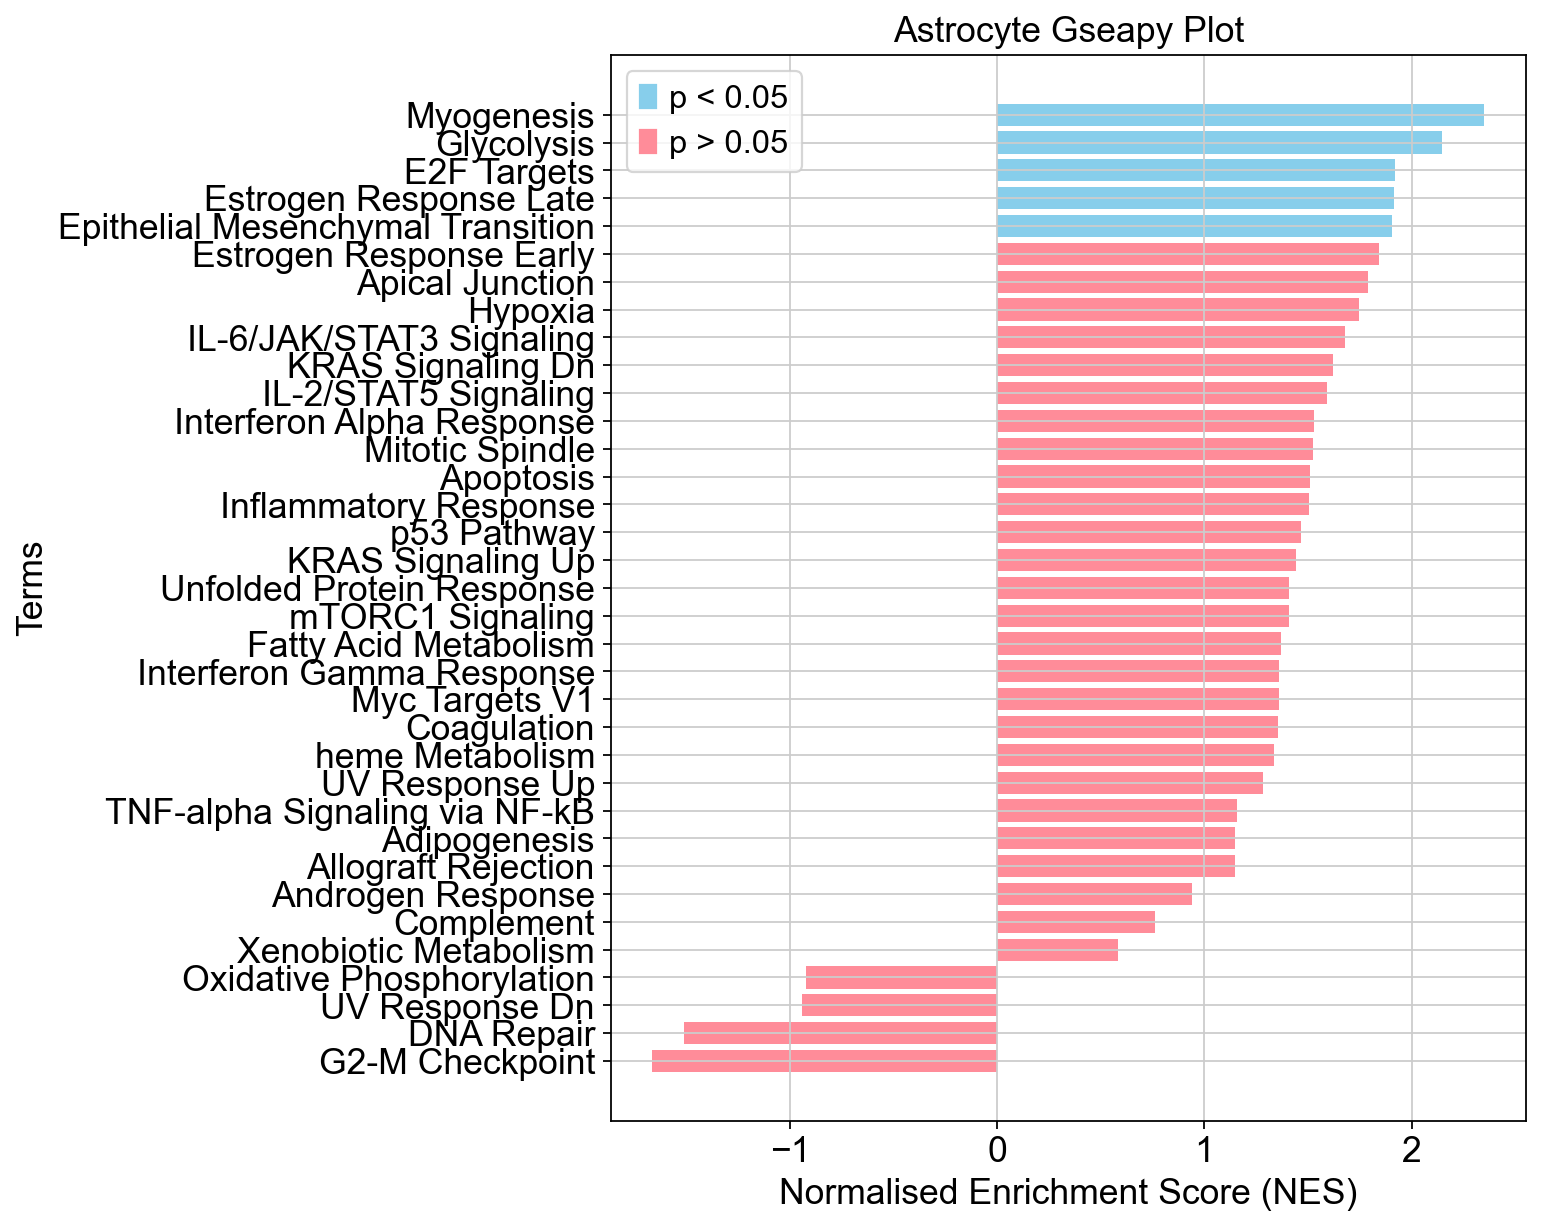

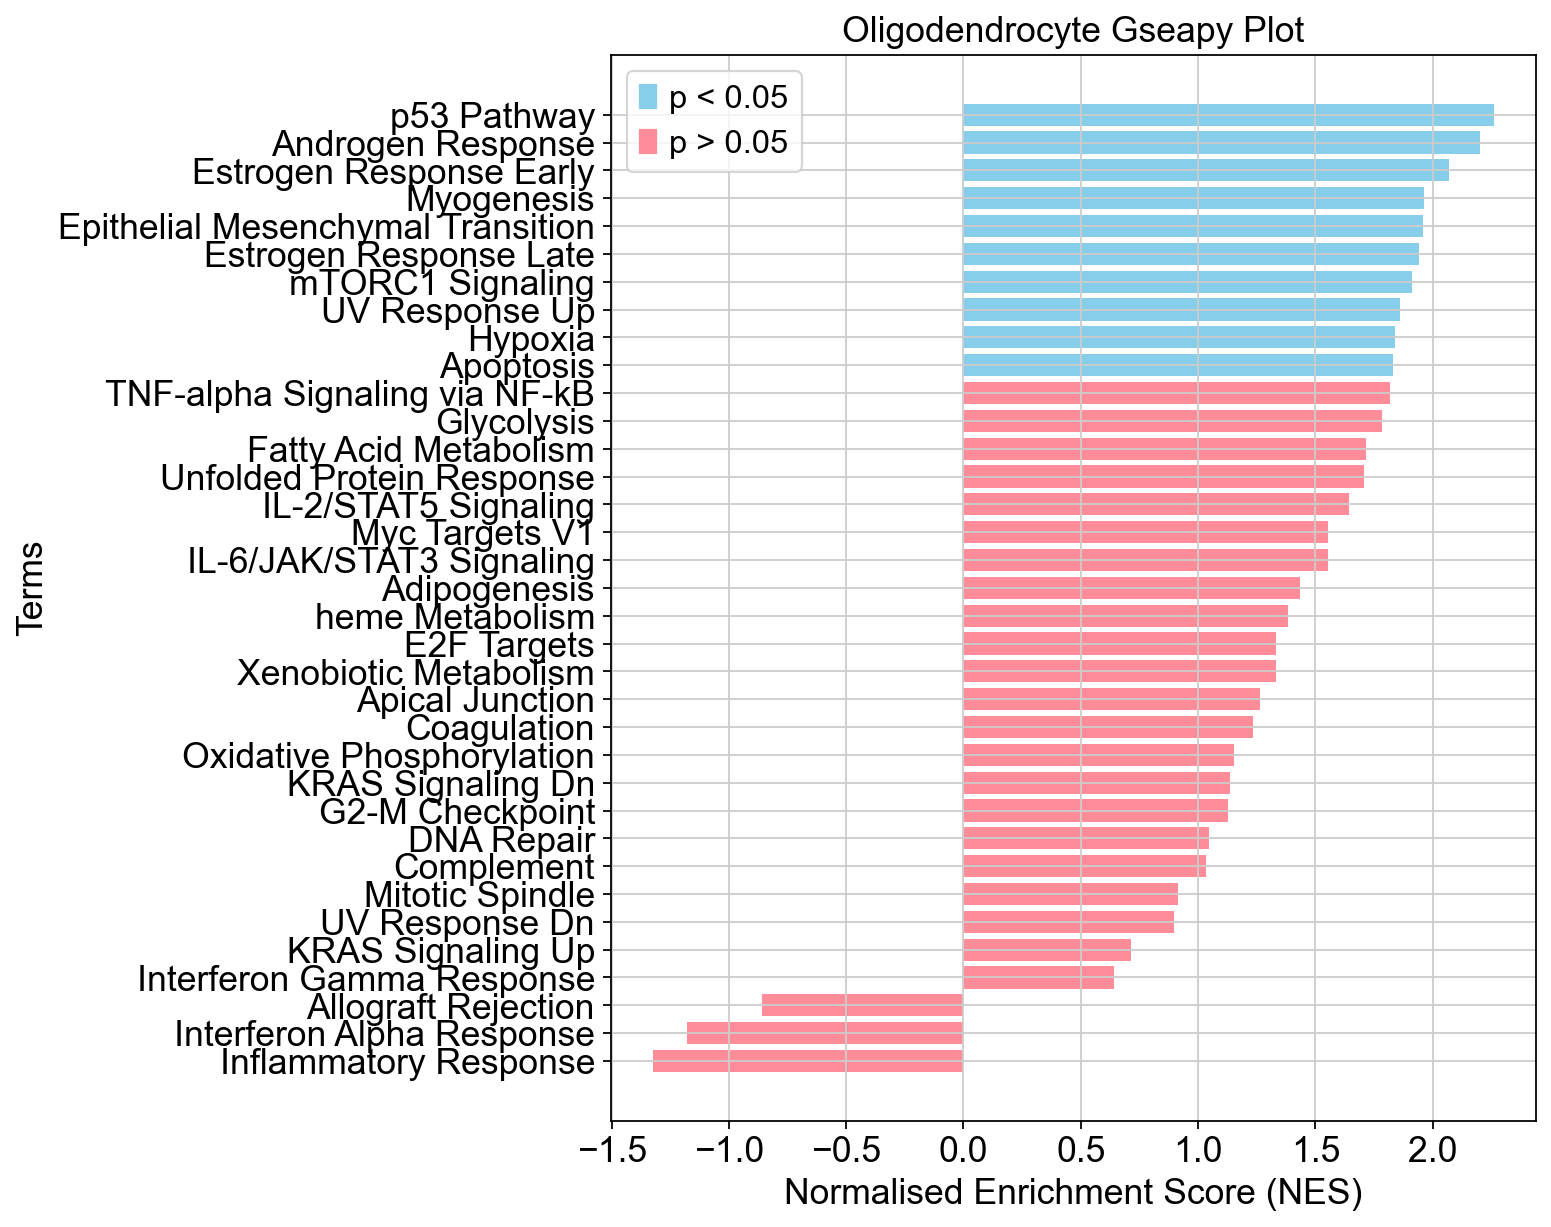

In [43]:
Astro_result_graph = plotting_gseapy(result_astro, 50, 'Astrocyte Gseapy Plot', 'Astrocyte_gseapy.pdf')
Oligo_result_graph = plotting_gseapy(result_oligo, 50, 'Oligodendrocyte Gseapy Plot', 'Oligodendrocyte_gseapy.pdf')

In [44]:
astrocyte_frame_raw = cell_type_frame(adata_raw, 'Astrocyte')
oligodendrocyte_frame_raw = cell_type_frame(adata_raw, 'Oligodendrocyte')

astrocyte_raw_disease_status = disease_status_for_celltype(adata_raw, 'Astrocyte')
oligodendrocyte_raw_disease_status = disease_status_for_celltype(adata_raw, 'Oligodendrocyte')





In [45]:
def calculating_entropy(cell_frame, disease_frame):
    
    healthy_mask = disease_frame == "Ct"
    disease_mask = disease_frame == "AD"

    healthy_expression = cell_frame[healthy_mask]
    disease_expression = cell_frame[disease_mask]

    # Calculate entropy for healthy and disease expression data
    healthy_entropy = healthy_expression.apply(lambda x: entropy(x.value_counts(normalize=True)), axis=1)
    disease_entropy = disease_expression.apply(lambda x: entropy(x.value_counts(normalize=True)), axis=1)
    
    healthy_entropy_values = healthy_entropy.to_list()
    disease_entropy_values = disease_entropy.to_list()
    
    return healthy_entropy_values, disease_entropy_values

In [46]:
entropy_astro = calculating_entropy(astrocyte_frame_raw, astrocyte_raw_disease_status)
entropy_oligo = calculating_entropy(oligodendrocyte_frame_raw, oligodendrocyte_raw_disease_status)


In [47]:
healthy_entropy_astro = entropy_astro[0]
disease_entropy_astro = entropy_astro[1]

healthy_entropy_oligo = entropy_oligo[0]
disease_entropy_oligo = entropy_oligo[1]

In [48]:
stat, p_value = mannwhitneyu(healthy_entropy_astro, disease_entropy_astro)
print(f'Mann-Whitney U test statistic: {stat}')
print(f'P-value: {p_value}')

Mann-Whitney U test statistic: 487145.0
P-value: 4.193031154760277e-15


In [49]:
def bootstrap_sampling(data, n_bootstrap):
    bootstrap_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means.append(np.mean(sample))
    return bootstrap_means

In [50]:
bootstrap_means_healthy_astro = bootstrap_sampling(healthy_entropy_astro, 1000)
bootstrap_means_disease_astro = bootstrap_sampling(disease_entropy_astro, 1000)


In [51]:
bootstrap_means_healthy_oligo = bootstrap_sampling(healthy_entropy_oligo, 1000)
bootstrap_means_disease_oligo = bootstrap_sampling(disease_entropy_oligo, 1000)

# Calculate the confidence intervals for each group
ci_healthy_oligo = np.percentile(bootstrap_means_healthy_oligo, [2.5, 97.5])
ci_disease_oligo = np.percentile(bootstrap_means_disease_oligo, [2.5, 97.5])

ci_healthy_astro = np.percentile(bootstrap_means_healthy_astro, [2.5, 97.5])
ci_disease_astro = np.percentile(bootstrap_means_disease_astro, [2.5, 97.5])

In [52]:
print('95% CI for healthy Astrocyte entropy:', ci_healthy_astro)
print('95% CI for disease Astrocyte entropy:', ci_disease_astro)
print('95% CI for healthy Oligodendrocyte entropy:', ci_healthy_oligo)
print('95% CI for disease Oligodendrocyte entropy:', ci_disease_oligo)

95% CI for healthy Astrocyte entropy: [0.36763328 0.37594779]
95% CI for disease Astrocyte entropy: [0.32143081 0.33942415]
95% CI for healthy Oligodendrocyte entropy: [0.25871595 0.26307128]
95% CI for disease Oligodendrocyte entropy: [0.2440618  0.24806668]


In [53]:
def CI_plot(ci_disease, ci_healthy, title, graph_name):
    mean_healthy = sum(ci_healthy) / 2
    mean_disease = sum(ci_disease) / 2

    # Positions of the groups on the x-axis
    x_positions = [0.5, 1]

    # Mean values for each group
    means = [mean_healthy, mean_disease]

    # Error values (distance from mean to the lower and upper confidence limits)
    errors = [[mean_healthy - ci_healthy[0], mean_disease - ci_disease[0]],
              [ci_healthy[1] - mean_healthy, ci_disease[1] - mean_disease]]

    # Creating the interval plot
    plt.errorbar(x=x_positions[0], y=means[0], yerr=[[errors[0][0]], [errors[1][0]]], fmt='o', color='#6FA0D6', capsize=5, capthick=2, label='Alzheimer\'s Disease')
    plt.errorbar(x=x_positions[1], y=means[1], yerr=[[errors[0][1]], [errors[1][1]]], fmt='o', color='#FF8C99', capsize=5, capthick=2, label='Healthy')

    # Adding custom x-axis labels
    plt.xticks(x_positions, ['AD', 'CT'], fontsize=12)  # Here we set the custom labels and their font size

    # Other plot settings
    plt.xlim(0, 1.5)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.ylabel('Mean Entropy', fontsize=12)
    fig = plt.gcf()
    ax = plt.gca()
    ax.yaxis.offsetText.set_visible(False)
    ax.set_ylabel(f'Mean Entropy (1e-1)', fontsize=12)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.legend(loc='best', fontsize=12)

    # Adding a title
    plt.title(title, fontsize=14)

    # Set tick label font size
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

    # Displaying the plot
    plt.savefig(graph_name)
    plt.show()

In [54]:
CI_plot(ci_disease_astro, ci_healthy_astro, '95% significance Entropy values of Astrocytes', 'Astrocyte_entropy.pdf')
CI_plot(ci_disease_oligo, ci_healt hy_oligo, '95% significance Entropy values of Oligodendrocytes', 'Oligodendrocyte_entropy.pdf')

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2114094743.py, line 2)